<a href="https://colab.research.google.com/github/KarltonBotics/Integrador_CentinelAI/blob/main/Avances_1_3_centinelAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 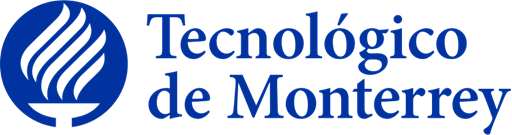


Maestría en Inteligencia Artificial Aplicada
**texto en negrita**
Proyecto Integrador
Septiembre – Diciembre
2025

Actividad 3
Avance 1. Análisis exploratorio de datos

Docentes:

*  Dra. Grettel Barceló Alonso
*  Dra. Verónica Sandra Guzmán De Valle

Asesor:

*   Dr. Luis Eduardo Falcón

Alumno:
*   Carlos Enríquez Gorgonio
A01793102
  
Septiembre 2025


#<mark>** AVANCE 1**</mark>
<p style="text-align: justify;"> Este primer avance consiste en realizar un análisis exploratorio de datos (EDA - Exploratory Data Analysis), es decir, describir los datos utilizando técnicas estadísticas y de visualización (análisis univariante y bi/multivariante) para hacer enfoque en sus aspectos más relevantes, así como aplicar y justificar operaciones de preprocesamiento, relacionadas con el manejo de valores faltantes, atípicos y alta cardinalidad. Es importante que incluyan sus conclusiones del EDA, identificando tendencias o relaciones importantes. </dp>
Las siguientes son algunas de las preguntas comunes que podrán abordar a través del EDA:

    ¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?
    ¿Cuáles son las estadísticas resumidas del conjunto de datos?
    ¿Hay valores atípicos en el conjunto de datos?
    ¿Cuál es la cardinalidad de las variables categóricas?
    ¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?
    ¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo).
    ¿Hay correlación entre las variables dependientes e independientes?
    ¿Cómo se distribuyen los datos en función de diferentes categorías? (análisis bivariado)
    ¿Se deberían normalizar las imágenes para visualizarlas mejor?
    ¿Hay desequilibrio en las clases de la variable objetivo?

</div>

**1.-IMPORTACIÓN DE LIBRERíAS**

In [74]:
import folium #Mapa
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import pyproj
from scipy.stats import skew
from tabulate import tabulate
from scipy.stats import chi2_contingency
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose

**2.-CARGA Y VISUALIZACIÓN DE ENCABEZADOS DEL DATASET**

El análisis de datos ha ido evolucionando a lo largo de las últimas 3 semanas, debido al tiempo en que las instituciones tardan en exportar su información y el DataSet creció de 500 registros a 100 y actualmente ya se cuenta con la versión definitiva de registros, sin embargo, se considera el DataSet A, debido a que se tiene la intención de añadir nuevos registros en un DataSet B, que nos permitan aumentar el alcance de las predicciones. Pero es necesario señalar, que la base de registros principales ya están integrados en este análisis.

El ejercicio se inicio con DataSets incompletos, llamado:<br>
**df_forestal**<br>
**DataSetFinal25_17**<br>

El nombre de nuestro DataSet Final en Excel es:<br>
**DataSetFinal25_13_A**<br>


In [2]:
#file_path = '/mnt/DataSetFinal25_17.xlsx'
file_path = '/mnt/DataSetFinal25_13_A.xlsx'
df = pd.read_excel(file_path, header=0,)
df.head()

dimensiones = df.shape
print(f"El DataFrame tiene: {dimensiones[0]} filas")
print(f"El DataFrame tiene: {dimensiones[1]} columnas")

El DataFrame tiene: 3750 filas
El DataFrame tiene: 31 columnas


**COMENTARIOS:**<br>
Nuestro DataSet tiene las cantidad de columnas y registros correspondientes a nuestro archivo original<br><br>
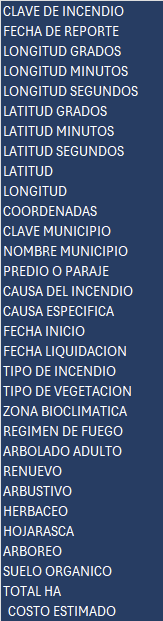
<br><br><br>
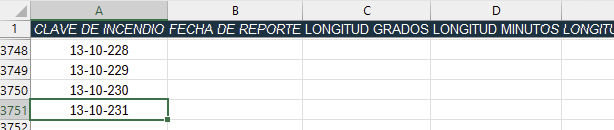




**3.-COMPROBACIÓN DE LOS TIPOS DE DATOS DE CADA COLUMNA**

In [3]:
print(df.dtypes)

CLAVE DE INCENDIO      object
FECHA DE REPORTE       object
LONGITUD GRADOS       float64
LONGITUD MINUTOS      float64
LONGITUD SEGUNDOS     float64
LATITUD GRADOS        float64
LATITUD MINUTOS       float64
LATITUD SEGUNDOS       object
LATITUD               float64
LONGITUD              float64
COORDENADAS            object
CLAVE MUNICIPIO       float64
NOMBRE MUNICIPIO       object
PREDIO O PARAJE        object
CAUSA DEL INCENDIO     object
CAUSA ESPECIFICA       object
FECHA INICIO           object
FECHA LIQUIDACION      object
TIPO DE INCENDIO       object
TIPO DE VEGETACION     object
ZONA BIOCLIMATICA      object
REGIMEN DE FUEGO       object
ARBOLADO ADULTO       float64
RENUEVO                object
ARBUSTIVO             float64
HERBACEO              float64
HOJARASCA             float64
ARBOREO               float64
SUELO ORGANICO        float64
TOTAL HA              float64
COSTO ESTIMADO        float64
dtype: object


**COMENTARIOS:**<br>

Se observa que nuestros features numéricos están en tipo float64, lo que es apropiado para nuestra actividad, sin embargo, nuestros valores tipo fecha se encuentran en formato object, por lo que posteriormente en la actividad 2 se procederá a realizar la transformación correspondiente.

NOTA: Antes de trabajar, debemos asegurarnos que nuestros encabezados no tienen acentos ni espacios de mas.

Y nos aseguramos que todos nuestros valores sean convertidos a mayusculas

In [4]:
df.columns = df.columns.str.strip()

Se observan problemas al tener los registros de fechas como objetos, asi que adelantando el proceso de limpieza, se modificaran unicamente los datos tipo fecha

In [5]:
columnas_a_convertir = ['FECHA DE REPORTE', 'FECHA INICIO', 'FECHA LIQUIDACION']
for columna in columnas_a_convertir:
    if columna in df.columns:
        # Intenta convertir primero los números de serie de Excel
        # La clave es añadir origin='1899-12-30'
        fechas_numericas = pd.to_datetime(
            pd.to_numeric(df[columna], errors='coerce'),
            unit='d',
            origin='1899-12-30'  # <-- ESTA ES LA CORRECCIÓN
        )

        # Intenta convertir las que no son numéricas (texto)
        fechas_texto = pd.to_datetime(df[columna], dayfirst=True, errors='coerce')

        # Combina ambos resultados: usa las fechas numéricas convertidas
        # y rellena los huecos con las fechas de texto convertidas.
        df[columna] = fechas_numericas.fillna(fechas_texto)

        print(f"Columna '{columna}' convertida exitosamente.")
    else:
        print(f"Advertencia: La columna '{columna}' no se encontró en el DataFrame.")

# Elimina las filas donde la conversión finalizó con un valor nulo en 'FECHA INICIO'
df.dropna(subset=['FECHA INICIO'], inplace=True)

Columna 'FECHA DE REPORTE' convertida exitosamente.
Columna 'FECHA INICIO' convertida exitosamente.
Columna 'FECHA LIQUIDACION' convertida exitosamente.


In [6]:
for columna in df.columns:
    if df[columna].dtype == 'object':
        df[columna] = df[columna].astype(str).str.upper()

In [7]:
print(df.dtypes)

CLAVE DE INCENDIO             object
FECHA DE REPORTE      datetime64[ns]
LONGITUD GRADOS              float64
LONGITUD MINUTOS             float64
LONGITUD SEGUNDOS            float64
LATITUD GRADOS               float64
LATITUD MINUTOS              float64
LATITUD SEGUNDOS              object
LATITUD                      float64
LONGITUD                     float64
COORDENADAS                   object
CLAVE MUNICIPIO              float64
NOMBRE MUNICIPIO              object
PREDIO O PARAJE               object
CAUSA DEL INCENDIO            object
CAUSA ESPECIFICA              object
FECHA INICIO          datetime64[ns]
FECHA LIQUIDACION     datetime64[ns]
TIPO DE INCENDIO              object
TIPO DE VEGETACION            object
ZONA BIOCLIMATICA             object
REGIMEN DE FUEGO              object
ARBOLADO ADULTO              float64
RENUEVO                       object
ARBUSTIVO                    float64
HERBACEO                     float64
HOJARASCA                    float64
A

In [8]:
total_registros, total_columnas = df.shape
print(f"Total de Registros: {total_registros}")
print(f"Total de Columnas:  {total_columnas}")

Total de Registros: 3741
Total de Columnas:  31


**COMENTARIOS:**<br>

Despues de la conversion de registros, se observa la desaparicion de 10 registros.

In [9]:
df.to_excel('/mnt/validar.xlsx', index=False)

**4.- VISUALIZACIÓN DE LA DISTRIBUCIÓN**<br>

Para esta distribución utilizaremos un histograma que nos permitira ver la cantidad de eventos usando el feature de fecha, pretendemos observar los meses de cada año con mayor cantidad de eventos.


Gráfico 'histograma_por_año.png' guardado.


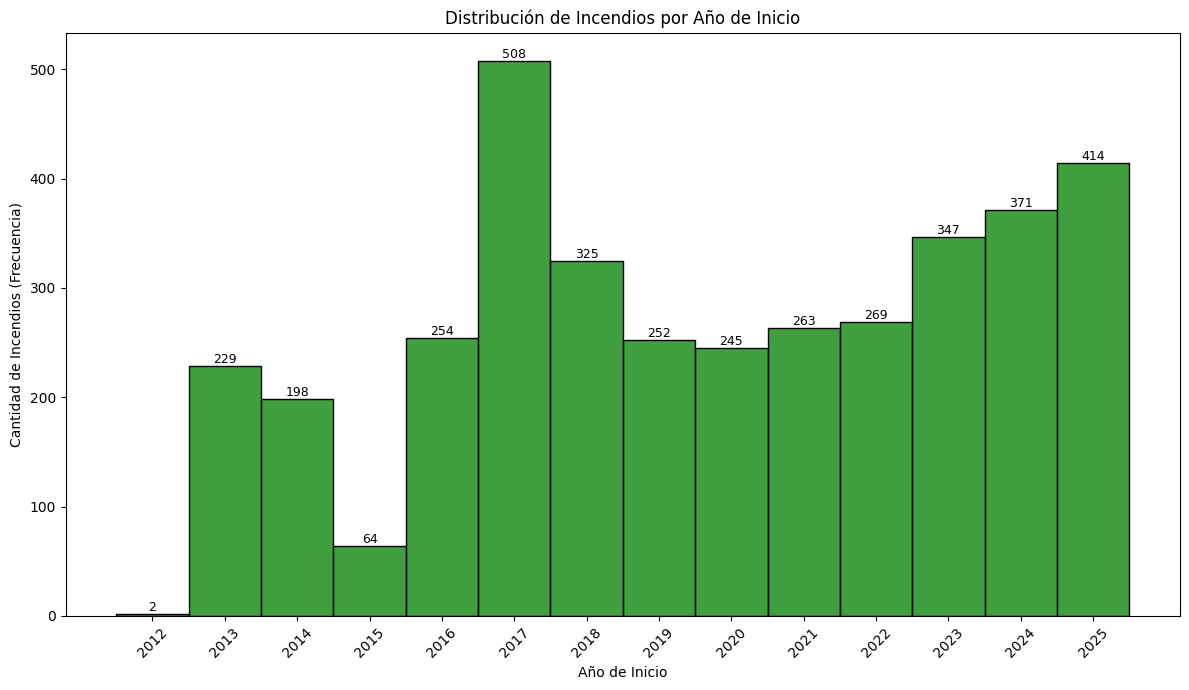

In [10]:

years = df['FECHA INICIO'].dt.year

# Configurar y crear el gráfico
plt.figure(figsize=(12, 7))
ax = sns.histplot(x=years, kde=False, discrete=True, color='green')

# Añadir etiquetas de valor a cada barra
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width() / 2.,
                p.get_height(),
                f'{int(p.get_height())}',
                fontsize=9,
                ha='center',
                va='bottom')

plt.title('Distribución de Incendios por Año de Inicio')
plt.xlabel('Año de Inicio')
plt.ylabel('Cantidad de Incendios (Frecuencia)')
if not years.empty:
    plt.xticks(sorted(years.unique()), rotation=45)
plt.tight_layout()

plt.savefig('histograma_por_año.png')
print("Gráfico 'histograma_por_año.png' guardado.")
plt.show()

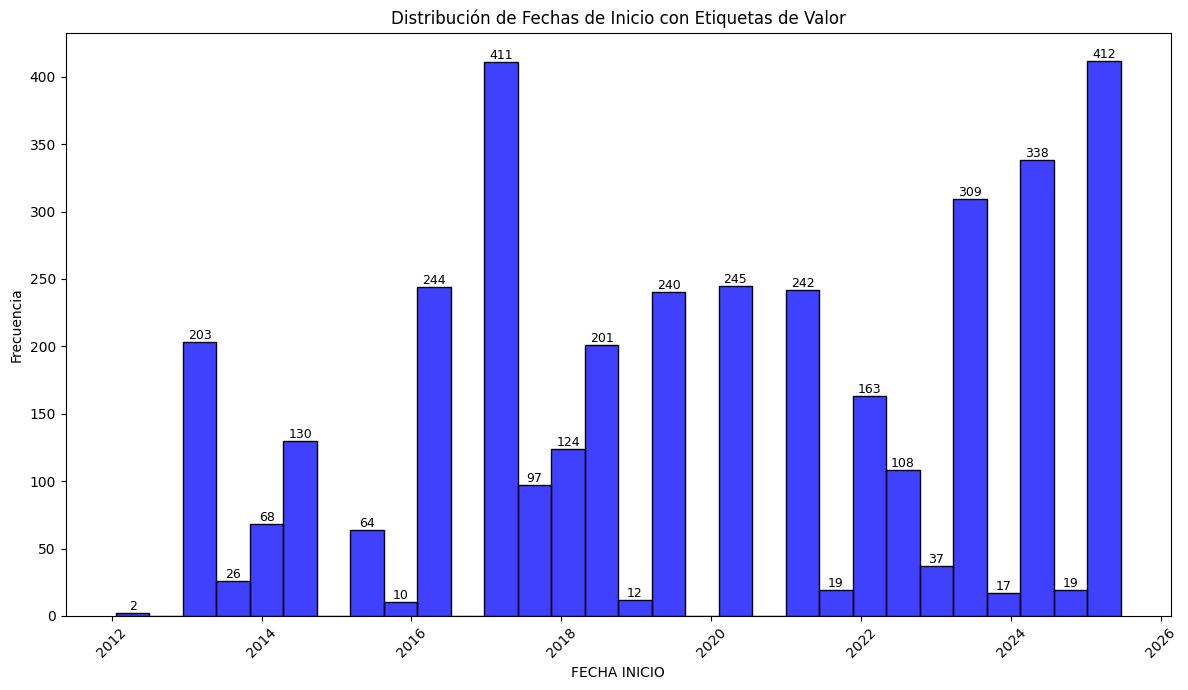

In [11]:
df['FECHA INICIO'] = pd.to_datetime(df['FECHA INICIO'], errors='coerce')
df.dropna(subset=['FECHA INICIO'], inplace=True)

plt.figure(figsize=(12, 7))
ax = sns.histplot(df['FECHA INICIO'], kde=False, bins=30, color='blue')

for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width() / 2.,
                p.get_height(),
                f'{int(p.get_height())}',
                fontsize=9,
                ha='center',
                va='bottom')

plt.title('Distribución de Fechas de Inicio con Etiquetas de Valor')
plt.xlabel('FECHA INICIO')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('histograma_con_etiquetas.png')
plt.show()

In [12]:
#Antes de crear nuevas columnas de AÑO, MES Y NUMERO DE MES, RESPALDAMOS NUESTRO DATAFRAME
df_original = df

In [13]:
#df['FECHA INICIO'] = pd.to_datetime(df['FECHA INICIO'], dayfirst=True)

conteo_por_anio = df['FECHA INICIO'].dt.year.value_counts().sort_index()

tabla_resultado = conteo_por_anio.reset_index()
tabla_resultado.columns = ['Año', 'Total de Registros']

print(tabla_resultado)

     Año  Total de Registros
0   2012                   2
1   2013                 229
2   2014                 198
3   2015                  64
4   2016                 254
5   2017                 508
6   2018                 325
7   2019                 252
8   2020                 245
9   2021                 263
10  2022                 269
11  2023                 347
12  2024                 371
13  2025                 414


**COMENTARIOS:**<br>

Se observa una distribución multimodal, aunque tambien puede describirse como desbalanceada ya que os años 2017 y 2025 representan los picos de los incendios


**5.- VISUALIZACIÓN DE ESTADÍSTICAS DESCRIPTIVAS**


In [14]:
df.describe()

,FECHA DE REPORTE,LONGITUD GRADOS,LONGITUD MINUTOS,LONGITUD SEGUNDOS,LATITUD GRADOS,LATITUD MINUTOS,LATITUD,LONGITUD,CLAVE MUNICIPIO,FECHA INICIO,FECHA LIQUIDACION,ARBOLADO ADULTO,ARBUSTIVO,HERBACEO,HOJARASCA,ARBOREO,SUELO ORGANICO,TOTAL HA,COSTO ESTIMADO
count,1132,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1.353000e+03,1.353000e+03,1132.000000,3741,3311,1132.000000,2934.000000,3165.000000,2927.000000,765.000000,176.000000,3741.000000,1.418000e+03
mean,2024-08-04 08:25:24.699646464,104.711131,31.411661,29.590822,23.108657,34.779152,2.352523e+07,1.047702e+08,18.274735,2020-01-08 09:47:40.898155776,2020-11-02 12:37:54.491090176,1.875474,62.424834,66.777096,67.695219,14.589919,14.068807,168.943821,2.316257e+04
min,2023-03-16 16:54:00,103.000000,0.000000,0.000000,22.000000,0.000000,2.340950e+06,1.052052e+06,1.000000,2012-01-22 00:00:00,2015-04-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2023-08-17 15:59:15,104.000000,20.750000,14.000000,22.000000,17.000000,2.258500e+07,1.043530e+08,14.000000,2017-05-06 10:00:00,2018-02-25 21:59:30,0.000000,1.000000,2.000000,2.000000,0.000000,1.000000,5.550000,4.870000e+03
50%,2024-07-22 13:28:30,104.500000,32.000000,30.000000,23.000000,41.000000,2.335550e+07,1.050644e+08,14.000000,2020-04-17 16:30:00,2021-02-10 20:00:00,0.000000,6.000000,9.000000,9.090000,1.000000,2.000000,21.420000,9.872000e+03
75%,2025-06-05 12:58:15.000000256,105.000000,42.000000,44.000000,24.000000,51.000000,2.419330e+07,1.054029e+08,23.000000,2023-05-17 00:00:00,2023-06-19 00:00:00,0.000000,30.000000,36.000000,40.000000,5.000000,6.000000,81.719400,1.870000e+04
max,2025-08-18 10:30:00,107.000000,59.000000,59.990000,26.000000,59.000000,2.644256e+07,1.070631e+08,39.000000,2025-06-18 00:00:00,2025-06-20 00:00:00,190.000000,5950.000000,14289.000000,3060.414600,1660.000000,415.000000,23809.000000,1.215752e+06
std,NaN,0.816789,14.795696,17.221570,1.047769,19.059792,1.120551e+06,4.942938e+06,9.177952,NaN,NaN,10.188370,254.530924,342.688981,219.145012,80.054504,49.380107,712.018172,6.153632e+04


In [15]:
df.describe(include='all')

,CLAVE DE INCENDIO,FECHA DE REPORTE,LONGITUD GRADOS,LONGITUD MINUTOS,LONGITUD SEGUNDOS,LATITUD GRADOS,LATITUD MINUTOS,LATITUD SEGUNDOS,LATITUD,LONGITUD,...,REGIMEN DE FUEGO,ARBOLADO ADULTO,RENUEVO,ARBUSTIVO,HERBACEO,HOJARASCA,ARBOREO,SUELO ORGANICO,TOTAL HA,COSTO ESTIMADO
count,3741,1132,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,3741,1.353000e+03,1.353000e+03,...,3741,1132.000000,3741,2934.000000,3165.000000,2927.000000,765.000000,176.000000,3741.000000,1.418000e+03
unique,2324,NaN,NaN,NaN,NaN,NaN,NaN,265,NaN,NaN,...,5,NaN,581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,25,NaN,NaN,NaN,NaN,NaN,NaN,NAN,NaN,NaN,...,NAN,NaN,NAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7,NaN,NaN,NaN,NaN,NaN,NaN,2606,NaN,NaN,...,2616,NaN,1426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2024-08-04 08:25:24.699646464,104.711131,31.411661,29.590822,23.108657,34.779152,NaN,2.352523e+07,1.047702e+08,...,NaN,1.875474,NaN,62.424834,66.777096,67.695219,14.589919,14.068807,168.943821,2.316257e+04
min,NaN,2023-03-16 16:54:00,103.000000,0.000000,0.000000,22.000000,0.000000,NaN,2.340950e+06,1.052052e+06,...,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,NaN,2023-08-17 15:59:15,104.000000,20.750000,14.000000,22.000000,17.000000,NaN,2.258500e+07,1.043530e+08,...,NaN,0.000000,NaN,1.000000,2.000000,2.000000,0.000000,1.000000,5.550000,4.870000e+03
50%,NaN,2024-07-22 13:28:30,104.500000,32.000000,30.000000,23.000000,41.000000,NaN,2.335550e+07,1.050644e+08,...,NaN,0.000000,NaN,6.000000,9.000000,9.090000,1.000000,2.000000,21.420000,9.872000e+03
75%,NaN,2025-06-05 12:58:15.000000256,105.000000,42.000000,44.000000,24.000000,51.000000,NaN,2.419330e+07,1.054029e+08,...,NaN,0.000000,NaN,30.000000,36.000000,40.000000,5.000000,6.000000,81.719400,1.870000e+04
max,NaN,2025-08-18 10:30:00,107.000000,59.000000,59.990000,26.000000,59.000000,NaN,2.644256e+07,1.070631e+08,...,NaN,190.000000,NaN,5950.000000,14289.000000,3060.414600,1660.000000,415.000000,23809.000000,1.215752e+06


In [16]:
columnas_seleccionadas = df[['FECHA INICIO', 'NOMBRE MUNICIPIO', 'TIPO DE VEGETACION']]
#columnas_seleccionadas.describe(include='all')
columnas_seleccionadas.describe()

,FECHA INICIO
count,3741
mean,2020-01-08 09:47:40.898155776
min,2012-01-22 00:00:00
25%,2017-05-06 10:00:00
50%,2020-04-17 16:30:00
75%,2023-05-17 00:00:00
max,2025-06-18 00:00:00


**COMENTARIOS:**<br>

No se pueden obtener observaciones relevantes ya que se está trabajando con valores que por si solos no tienen mucho sentido, por ejemplo, la media de las coordenadas no es analizable de esta forma, se requiere un método de recurrencia para nuestro objetivo.<br>

Sin embargo, hay datos que nos permiten hacer observaciones simples como la fecha de nuestro primer evento al ser el valor mínimo en la FECHA INICIO. Así como los valores top en municipio correspondiente al “Mezquital” y al tipo de vegetación “Bosque de Pino”, y la causa “intencional”



**6.-IDENTIFICACIÓN DE COLUMNAS COMPLETAS Y COLUMNAS CON DATOS FALTANTES**

In [17]:
conteo_faltantes = df.isnull().sum()
columnas_completas = conteo_faltantes[conteo_faltantes == 0].index.tolist()

print("Las columnas que no tienen datos faltantes son:", columnas_completas)

Las columnas que no tienen datos faltantes son: ['CLAVE DE INCENDIO', 'LATITUD SEGUNDOS', 'COORDENADAS', 'NOMBRE MUNICIPIO', 'PREDIO O PARAJE', 'CAUSA DEL INCENDIO', 'CAUSA ESPECIFICA', 'FECHA INICIO', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'ZONA BIOCLIMATICA', 'REGIMEN DE FUEGO', 'RENUEVO', 'TOTAL HA']


In [18]:
faltantes = df.isna().sum()

porcentaje_faltantes = (faltantes / len(df)) * 100

resultado = pd.DataFrame({
    'Cantidad faltante': faltantes,
    'Porcentaje faltante': porcentaje_faltantes
})

print(resultado)

                    Cantidad faltante  Porcentaje faltante
CLAVE DE INCENDIO                   0             0.000000
FECHA DE REPORTE                 2609            69.740711
LONGITUD GRADOS                  2609            69.740711
LONGITUD MINUTOS                 2609            69.740711
LONGITUD SEGUNDOS                2609            69.740711
LATITUD GRADOS                   2609            69.740711
LATITUD MINUTOS                  2609            69.740711
LATITUD SEGUNDOS                    0             0.000000
LATITUD                          2388            63.833200
LONGITUD                         2388            63.833200
COORDENADAS                         0             0.000000
CLAVE MUNICIPIO                  2609            69.740711
NOMBRE MUNICIPIO                    0             0.000000
PREDIO O PARAJE                     0             0.000000
CAUSA DEL INCENDIO                  0             0.000000
CAUSA ESPECIFICA                    0             0.0000

**COMENTARIOS:**<br>

Afortunadamente los valores principales como FECHA INICIO y MUNICIPIO, ya nos permite trabaja correctamente para nuestro objetivo de identificación de eventos por ubicación geográfica.<br>

Cabe señalar que los features de LATITUD y LONGITUD dispersos en 6 columnas, pueden resultar llamativos por la cantidad de datos faltantes, que corresponden a la mitad del dataset, ya que derivado del análisis del primer dataset, como se comentó al inicio, tienen estas dos columnas distribuidas en 2 partes, sin embargo, posteriormente en la actividad 2, realizaremos la integración y por lo tanto nuestras columnas de LATITUD y LONGITUD quedaran sin datos faltantes.<br>

Por ultimo se observa que features relevantes como TIPO DE INCENDIO y TIPO DE VEGETACION tienen menos del 50% y 43.99% de valores faltantes respectivamente.

**7.- IDENTIFICACIÓN DE OUTLIERS**

El enfoque de nuestros outliers es ubicar las fechas y municipios con mayor cantidad de incendios

<mark>** Se crea las columnas Año y Mes_num**</mark>

In [19]:
df['FECHA INICIO'] = pd.to_datetime(df['FECHA INICIO'], errors='coerce')
df.dropna(subset=['FECHA INICIO'], inplace=True)

df['Año'] = df['FECHA INICIO'].dt.year
df['Mes_num'] = df['FECHA INICIO'].dt.month

conteo_mensual = df.groupby(['Año', 'Mes_num']).size().reset_index(name='Eventos')

df['Año'] = df['Año'].astype(int)
todos_los_meses = pd.DataFrame([(año, mes) for año in df['Año'].unique() for mes in range(1, 13)],
                               columns=['Año', 'Mes_num'])

conteo_mensual_completo = pd.merge(todos_los_meses, conteo_mensual, on=['Año', 'Mes_num'], how='left').fillna(0)

meses_dict = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
              7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}

conteo_mensual_completo['Mes'] = conteo_mensual_completo['Mes_num'].map(meses_dict)
conteo_mensual_completo['Eventos'] = conteo_mensual_completo['Eventos'].astype(int)


conteo_con_eventos = conteo_mensual_completo[conteo_mensual_completo['Eventos'] > 0]

conteo_final_ordenado = conteo_con_eventos.sort_values(by='Eventos', ascending=False)

print(conteo_final_ordenado[['Año', 'Mes', 'Eventos']])


      Año         Mes  Eventos
100  2017        Mayo      232
88   2018        Mayo      141
64   2020        Mayo      126
16   2024        Mayo      125
76   2019        Mayo      121
..    ...         ...      ...
72   2019       Enero        1
32   2023  Septiembre        1
96   2017       Enero        1
102  2017       Julio        1
132  2014       Enero        1

[81 rows x 3 columns]


Distribución de incidencias agrupando por meses del año

<mark>** Se crea la columna mes**</mark>

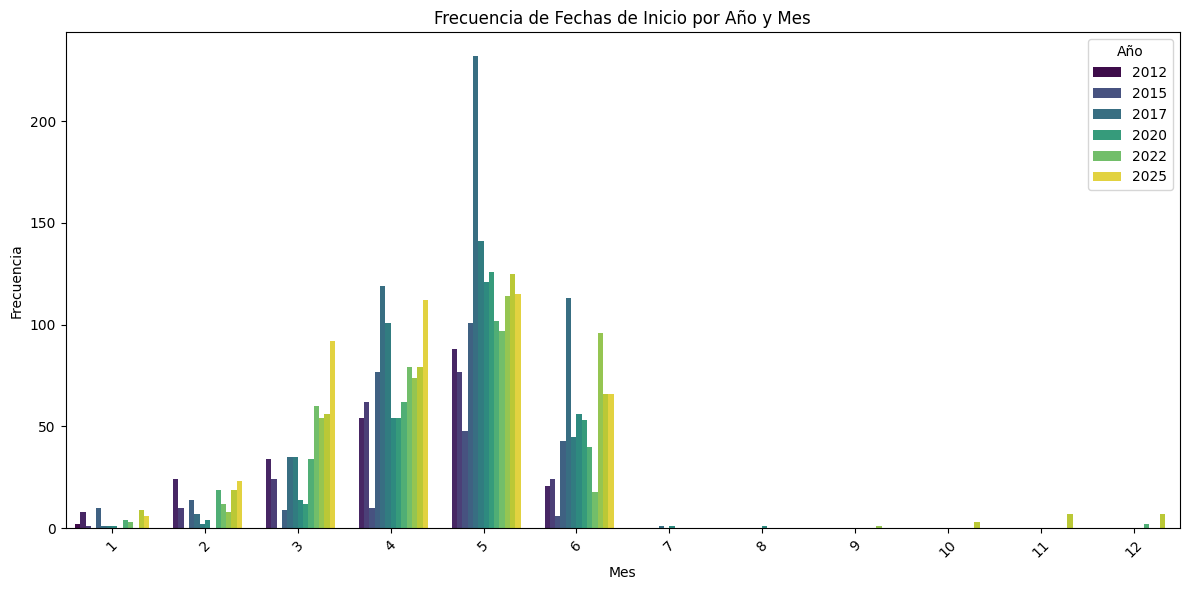

In [20]:
df['Mes'] = df['FECHA INICIO'].dt.month_name()

df_grouped = df.groupby(['Año', 'Mes']).size().reset_index(name='Frecuencia')

df_grouped['Mes'] = pd.to_datetime(df_grouped['Mes'], format='%B').dt.month  # Convertir mes a número
df_grouped = df_grouped.sort_values(by=['Año', 'Mes'])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_grouped, x='Mes', y='Frecuencia', hue='Año', palette='viridis')

plt.title('Frecuencia de Fechas de Inicio por Año y Mes')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()

plt.show()

Identificación de tendencias temporales con base en los features de fechas


/tmp/ipython-input-4192942049.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = df.set_index(col).resample('M').size()


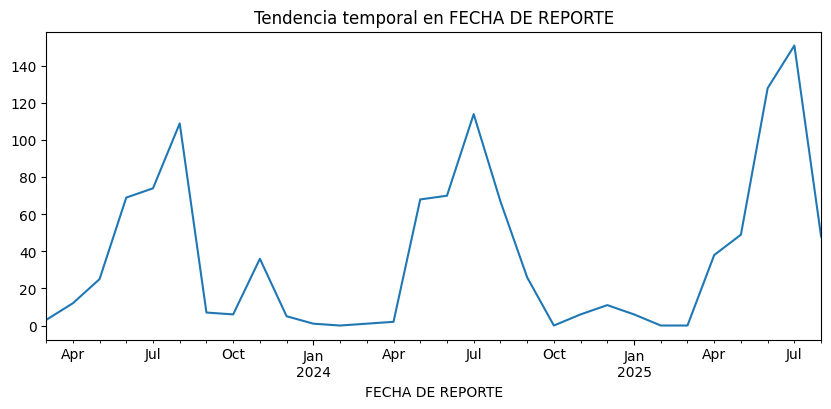

/tmp/ipython-input-4192942049.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = df.set_index(col).resample('M').size()


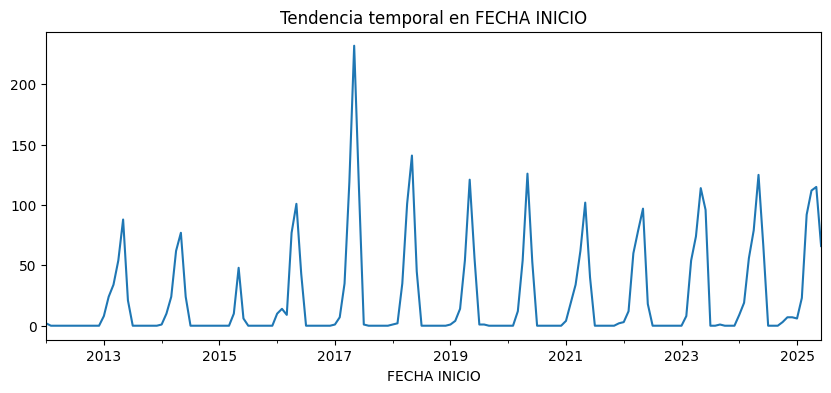

/tmp/ipython-input-4192942049.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = df.set_index(col).resample('M').size()


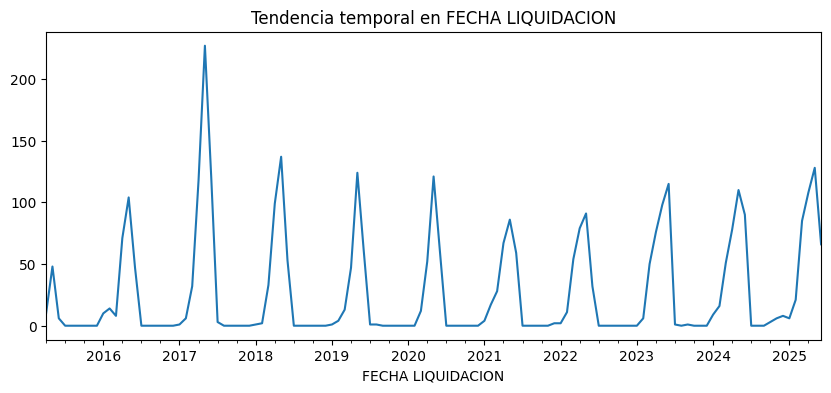

In [21]:
# Buscamos columnas que sean de tipo fecha
fechas = [c for c in df.columns if 'fecha' in c.lower() or 'date' in c.lower()]

for col in fechas:
    # Convertimos la columna a tipo datetime
    df[col] = pd.to_datetime(df[col], errors='coerce')
    # Reagregamos valores por mes
    serie = df.set_index(col).resample('M').size()

    # Graficamos evolución en el tiempo
    plt.figure(figsize=(10,4))
    serie.plot()
    plt.title(f'Tendencia temporal en {col}')
    plt.show()

**COMENTARIOS:**

Se identificaros 2 registros despreciables, tal vez erróneos correspondientes al año 2013, o tal vez fueron añadidos como parte de lo reportado al principio de 2013, sin embargo, esa cantidad no representa perdidas de datos significativos

In [22]:
df.columns

Index(['CLAVE DE INCENDIO', 'FECHA DE REPORTE', 'LONGITUD GRADOS',
       'LONGITUD MINUTOS', 'LONGITUD SEGUNDOS', 'LATITUD GRADOS',
       'LATITUD MINUTOS', 'LATITUD SEGUNDOS', 'LATITUD', 'LONGITUD',
       'COORDENADAS', 'CLAVE MUNICIPIO', 'NOMBRE MUNICIPIO', 'PREDIO O PARAJE',
       'CAUSA DEL INCENDIO', 'CAUSA ESPECIFICA', 'FECHA INICIO',
       'FECHA LIQUIDACION', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION',
       'ZONA BIOCLIMATICA', 'REGIMEN DE FUEGO', 'ARBOLADO ADULTO', 'RENUEVO',
       'ARBUSTIVO', 'HERBACEO', 'HOJARASCA', 'ARBOREO', 'SUELO ORGANICO',
       'TOTAL HA', 'COSTO ESTIMADO', 'Año', 'Mes_num', 'Mes'],
      dtype='object')

**ENFOQUE EN MUNICIPIOS Y NO EN FECHAS**


In [23]:
conteo_municipios = df['NOMBRE MUNICIPIO'].value_counts().reset_index()
conteo_municipios.columns = ['NOMBRE MUNICIPIO', 'Número de Incendios']

print("Municipios con mayor número de incendios:")
print(conteo_municipios.head(10))

Municipios con mayor número de incendios:
       NOMBRE MUNICIPIO  Número de Incendios
0             MEZQUITAL                 1401
1          PUEBLO NUEVO                  725
2               DURANGO                  422
3             SAN DIMAS                  305
4              TAMAZULA                  182
5            TEPEHUANES                  144
6  SANTIAGO PAPASQUIARO                  141
7               CANELAS                   86
8             GUANACEVÍ                   58
9                 TOPIA                   51


In [24]:
#print(conteo_municipios.head(30))
print(conteo_municipios)

        NOMBRE MUNICIPIO  Número de Incendios
0              MEZQUITAL                 1401
1           PUEBLO NUEVO                  725
2                DURANGO                  422
3              SAN DIMAS                  305
4               TAMAZULA                  182
5             TEPEHUANES                  144
6   SANTIAGO PAPASQUIARO                  141
7                CANELAS                   86
8              GUANACEVÍ                   58
9                  TOPIA                   51
10                 OTÁEZ                   45
11             GUANACEVI                   37
12              CANATLÁN                   25
13              CANATLAN                   19
14                 OTAEZ                   18
15           NUEVO IDEAL                   17
16                 LERDO                   16
17                OCAMPO                   14
18        NOMBRE DE DIOS                    8
19                SÚCHIL                    8
20          SAN BERNARDO          

**COMENTARIOS:**<br>

Se pueden observar claramente los outliers principalmente en las fechas, específicamente en la cantidad de eventos en el año 2017 y 2025, las tendencias centralizadas en los meses correspondientes a las estaciones de primavera y verano, así como 3 municipios que agrupan la mayor cantidad de eventos.

**8.-BÚSQUEDA INICIAL CORRELACIONES SIN NINGÚN TRATAMIENTO PREVIO DE DATOS**




Se ha generado el diagrama 'diagrama_asociacion_final.png' con éxito.

Matriz de V de Cramer:
                    NOMBRE MUNICIPIO  TIPO DE INCENDIO  TIPO DE VEGETACION  \
NOMBRE MUNICIPIO            1.000000          0.171691            0.297134   
TIPO DE INCENDIO            0.171691          1.000000            0.389355   
TIPO DE VEGETACION          0.297134          0.389355            1.000000   
MES_INICIO                  0.068937          0.072343            0.051793   

                    MES_INICIO  
NOMBRE MUNICIPIO      0.068937  
TIPO DE INCENDIO      0.072343  
TIPO DE VEGETACION    0.051793  
MES_INICIO            1.000000  


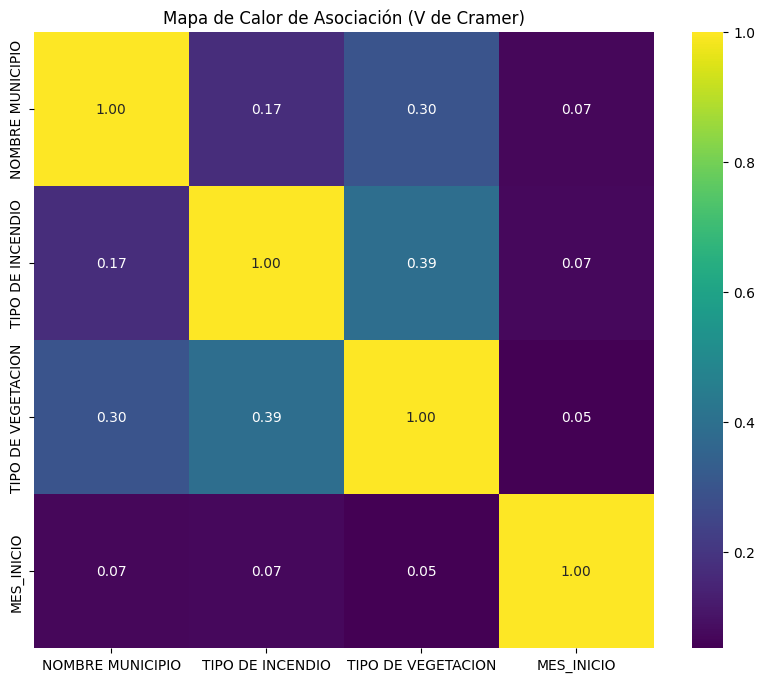

In [25]:
#df = pd.read_csv('DataSetFinal25_17.xlsx - Hoja1.csv', parse_dates=['FECHA INICIO'])

df['MES_INICIO'] = df['FECHA INICIO'].dt.strftime('%B')

cols = ['NOMBRE MUNICIPIO', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'MES_INICIO']
df_categorical = df[cols].copy()

def cramers_v(x, y):
    """ Calcula la V de Cramer para dos variables categóricas. """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    if min((k_corr-1), (r_corr-1)) == 0:
        return 0
    else:
        return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

cramers_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        cramers_matrix.loc[col1, col2] = cramers_v(df_categorical[col1], df_categorical[col2])

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Mapa de Calor de Asociación (V de Cramer)')
plt.savefig('diagrama_asociacion_final.png')

# Paso 8: Mostrar los resultados en la terminal
print("Se ha generado el diagrama 'diagrama_asociacion_final.png' con éxito.")
print("\nMatriz de V de Cramer:")
print(cramers_matrix)

**COMENTARIOS:**<br>

Se observa una correlación mayor entre el TIPO DE INCENDIO, TIPO DE VEGETACION y el NOMBRE MUNICIPIO, es decir si hay características que nos pueden dar resultados trascendentes en las predicciones del proyecto


**9.- DISTRIBUCIÓN BIVARIADA**

Usaremos TIPO DE VEGETACIÓN , TIPO DE INCENDIO, NOMBRE MUNICIPIO Y FECHA


Tabla de Distribución (Vegetación vs. Tipo de Incendio):
TIPO DE INCENDIO                        DE COPA  MIXTO   NAN  SUPERFICIAL  \
TIPO DE VEGETACION                                                          
BOSQUE DE AYARIN -BS                 0        0      0     0            3   
BOSQUE DE AYARÍN                     0        0      0     0            4   
BOSQUE DE ENCINO                     0        0      0    14          112   
BOSQUE DE ENCINO  - BQ               0        0      0     0           18   
BOSQUE DE ENCINO-PINO                0        0      0    38          120   
BOSQUE DE ENCINO-PINO - BQP          0        0      0     0           11   
BOSQUE DE GALERÍA                    0        0      0     0            1   
BOSQUE DE PINO                       0        1      0   132          448   
BOSQUE DE PINO - BP                  0        0      5     1          288   
BOSQUE DE PINO-ENCINO                1        0      0    73          370   
BOSQUE DE PINO-ENC

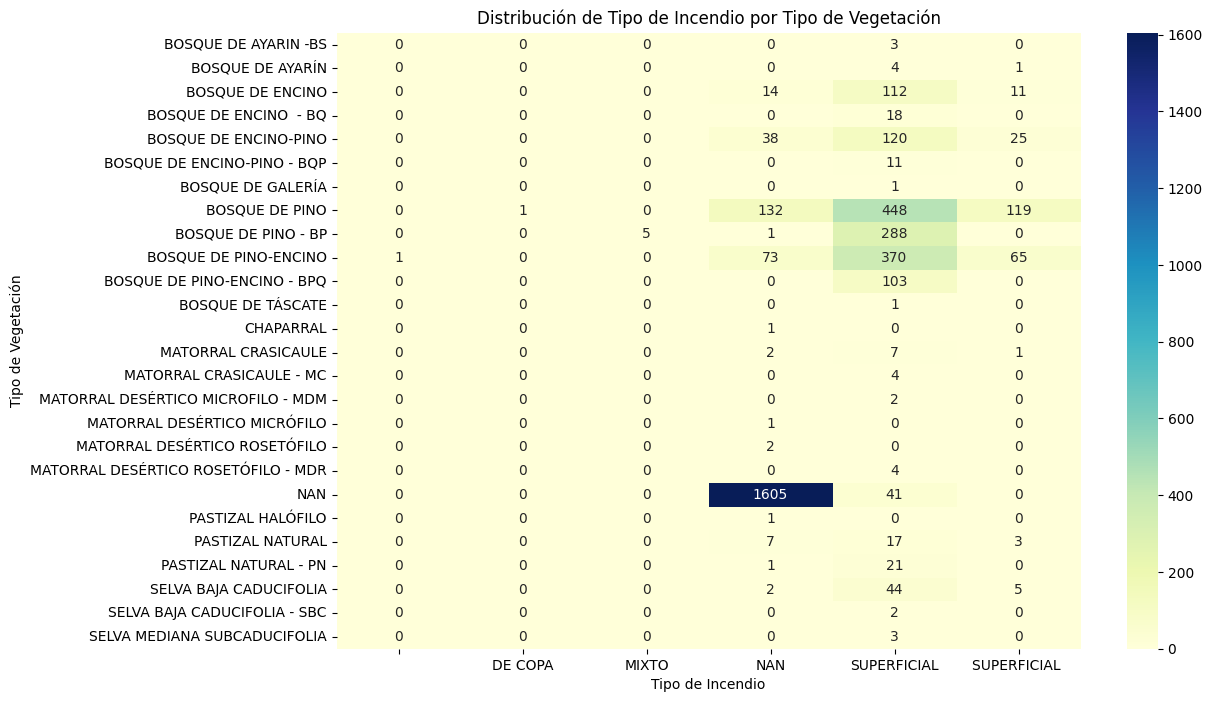

In [26]:

vegetacion_vs_incendio = pd.crosstab(df['TIPO DE VEGETACION'], df['TIPO DE INCENDIO'])

print("\nTabla de Distribución (Vegetación vs. Tipo de Incendio):")
print(vegetacion_vs_incendio)

plt.figure(figsize=(12, 8))
sns.heatmap(vegetacion_vs_incendio, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribución de Tipo de Incendio por Tipo de Vegetación')
plt.xlabel('Tipo de Incendio')
plt.ylabel('Tipo de Vegetación')
plt.savefig('analisis1_vegetacion_vs_incendio.png')


Tabla de Distribución (Municipio vs. Mes):
MES_INICIO            January  February  March  April  May  June  July  \
NOMBRE MUNICIPIO                                                         
CANATLAN                    0         2      6      2    4     5     0   
CANATLÁN                    0         2      3      5   11     4     0   
CANELAS                     1         4     14     15   40    11     0   
CUENCAME                    0         1      1      0    0     0     0   
CUENCAMÉ                    0         0      0      0    1     0     0   
DURANGO                    22        43     82    101  103    62     0   
EL ORO                      0         0      1      0    0     1     0   
GUANACEVI                   0         1      1     14   15     6     0   
GUANACEVÍ                   0         0      7     14   26    11     0   
LERDO                       2         4      7      3    0     0     0   
MAPIMÍ                      0         0      0      0    1     0    

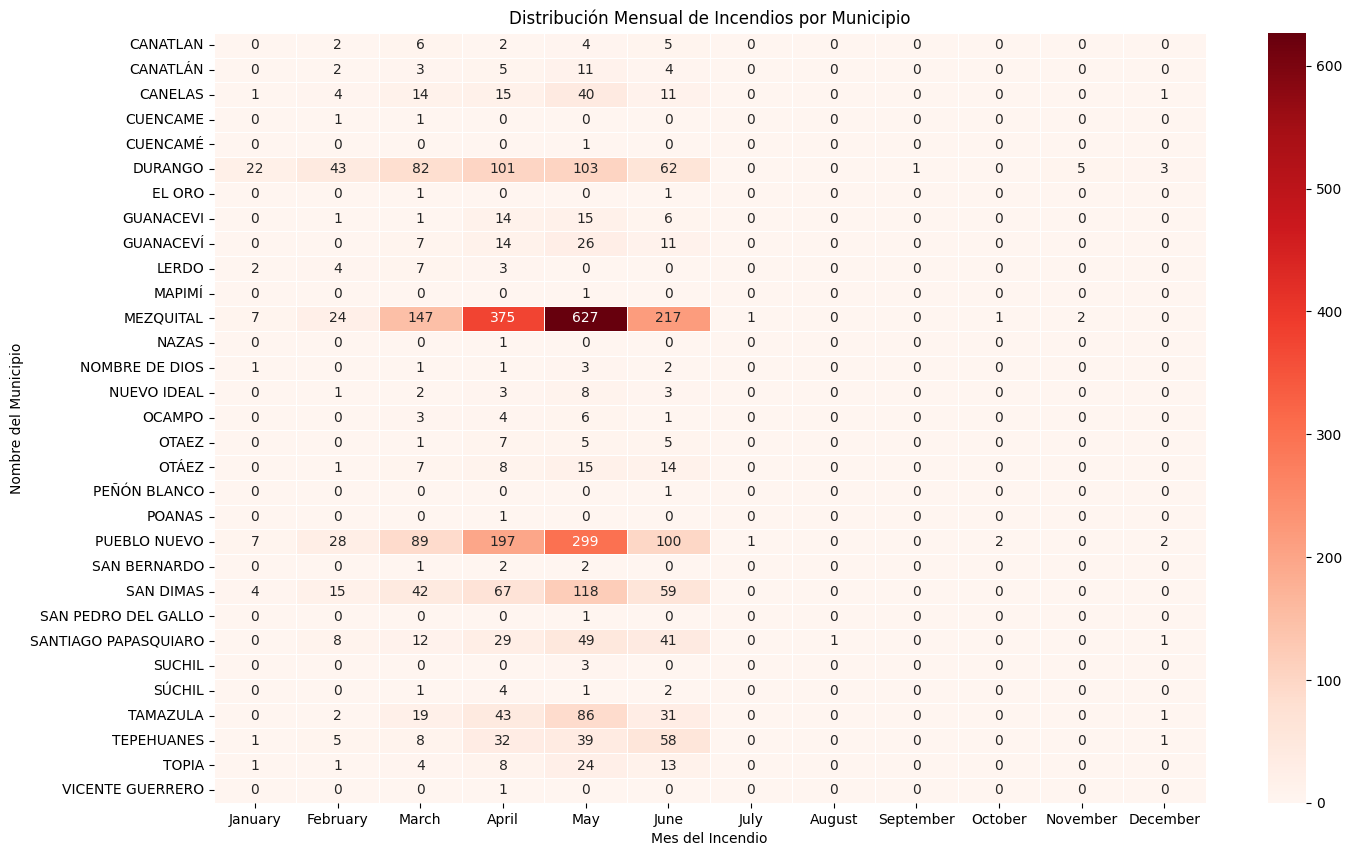

In [27]:
df['MES_INICIO'] = df['FECHA INICIO'].dt.month_name()

meses_en_orden = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['MES_INICIO'] = pd.Categorical(df['MES_INICIO'], categories=meses_en_orden, ordered=True)

municipio_vs_mes = pd.crosstab(df['NOMBRE MUNICIPIO'], df['MES_INICIO'])

print("\nTabla de Distribución (Municipio vs. Mes):")
print(municipio_vs_mes)

plt.figure(figsize=(16, 10))
sns.heatmap(municipio_vs_mes, annot=True, fmt='d', cmap='Reds', linewidths=.5)
plt.title('Distribución Mensual de Incendios por Municipio')
plt.xlabel('Mes del Incendio')
plt.ylabel('Nombre del Municipio')
plt.savefig('analisis2_municipio_vs_mes.png')

**COMENTARIOS:**<br>

Se observa nuevamente la predominancia de la relacion entre estas variables, confirmando nuesta linea de operacion


**10.- VARIABLES CATEGÓRICAS PRINCIPALES**

In [28]:
# Ver los valores únicos en la columna 'Tipo de Incendio'
valores_unicos_tipo_incedio = df['TIPO DE INCENDIO'].unique()
print("Valores únicos de 'TIPO DE INCENDIO':")
print(valores_unicos_tipo_incedio)

# Ver los valores únicos en la columna 'Municipio'
valores_unicos_municipio = df['NOMBRE MUNICIPIO'].unique()
print("\nValores únicos de 'Municipio':")
print(valores_unicos_municipio)

Valores únicos de 'TIPO DE INCENDIO':
['SUPERFICIAL' 'NAN' 'DE COPA' ' ' 'SUPERFICIAL ' 'MIXTO']

Valores únicos de 'Municipio':
['PUEBLO NUEVO' 'TOPIA' 'DURANGO' 'TEPEHUANES' 'CANELAS'
 'SANTIAGO PAPASQUIARO' 'SAN DIMAS' 'MEZQUITAL' 'TAMAZULA' 'GUANACEVÍ'
 'EL ORO' 'OTÁEZ' 'OCAMPO' 'CANATLÁN' 'NOMBRE DE DIOS' 'CUENCAMÉ' 'SÚCHIL'
 'NUEVO IDEAL' 'SAN BERNARDO' 'LERDO' 'VICENTE GUERRERO' 'NAZAS' 'MAPIMÍ'
 'POANAS' 'SAN PEDRO DEL GALLO' 'PEÑÓN BLANCO' 'CANATLAN' 'OTAEZ'
 'GUANACEVI' 'SUCHIL' 'CUENCAME']


In [29]:
columnas_categoricas = [
    'NOMBRE MUNICIPIO',
    'PREDIO O PARAJE',
    'CAUSA DEL INCENDIO',
    'CAUSA ESPECIFICA',
    'TIPO DE INCENDIO',
    'TIPO DE VEGETACION',
    'ZONA BIOCLIMATICA'
]

print("--- ANÁLISIS DE VALORES ÚNICOS POR COLUMNA ---\n")

for columna in columnas_categoricas:
    if columna in df.columns:

        valores_unicos = df[columna].unique()
        print("Valores Únicos encontrados:")
        for valor in valores_unicos:
            print(f"- {valor}")

        conteo_unicos = df[columna].nunique()
        print(f"\n>>> Sumatoria de Valores Únicos: {conteo_unicos}\n")
    else:
        print(f"Advertencia: La columna '{columna}' no se encontró en el archivo.")


--- ANÁLISIS DE VALORES ÚNICOS POR COLUMNA ---

Valores Únicos encontrados:
- PUEBLO NUEVO
- TOPIA
- DURANGO
- TEPEHUANES
- CANELAS
- SANTIAGO PAPASQUIARO
- SAN DIMAS
- MEZQUITAL
- TAMAZULA
- GUANACEVÍ
- EL ORO
- OTÁEZ
- OCAMPO
- CANATLÁN
- NOMBRE DE DIOS
- CUENCAMÉ
- SÚCHIL
- NUEVO IDEAL
- SAN BERNARDO
- LERDO
- VICENTE GUERRERO
- NAZAS
- MAPIMÍ
- POANAS
- SAN PEDRO DEL GALLO
- PEÑÓN BLANCO
- CANATLAN
- OTAEZ
- GUANACEVI
- SUCHIL
- CUENCAME

>>> Sumatoria de Valores Únicos: 31

Valores Únicos encontrados:
- COM SAN FRANCISCO DE LAJAS
- LA GUAJOLOTA
- EJIDO JOSÉ MARÍA MORELOS Y PAVÓN / RANCHO EL ZORRILLO
- EL NAYAR / SAN JOSÉ DE LA VINATA
- EJIDO JOSÉ MARÍA MORELOS Y BANDERAS DEL AGUILA
- COM LA SOLEDAD / LA TABLETA
- LOC VASCOGIL
- LA GUACAMAYA
- EJIDO EMPALME PURISIMA / RECTA DEL MADROÑO PASANDO NAVIOS
- LOC SAN ANTONIO DE LA CRUZ / LA SECUNDARIA
- COM SAN FRANCISCO DE OCOTÁN
- COM SANTA MARÍA DE OCOTÁN Y XOCONOXLE / ENTRONQUE LLANO GRANDE LA VENTANA SANTO NIÑO
- COM SANTA MARÍA DE O

**COMENTARIOS:**<br>

Volvemos a verificar<br>

**¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?**<br>
Si, se observan muchos valores faltantes, debido a las variaciones en el estilo de registro de l ainstitución que se han dado a lo largo de los años a partir del año 2013, sin embargo, los registros de las columnas 'CLAVE DE INCENDIO', 'NOMBRE MUNICIPIO', 'PREDIO O PARAJE', 'FECHA INICIO', 'TOTAL HA', no tienen datos faltantes, lo que permite trabajar perfectamente el modelo predictivo basado en fechas de incendios.<br>

Los patrones de ausencia son los datos registrados del año 2013 al 2022, y corresponden a las características de los incendios en cuanto al tipo de incendio, tipo de vegetación y los subtipos de vegetación.

**¿Cuáles son las estadísticas resumidas del conjunto de datos?**<br>
Se cuenta con 3,741 registros<br>
31 columnas<br>

Las columnas principales se encuentran en formato fecha hora, lo que facilita considerablemente el análisis de la información, así como la extracción de valores como numero de mes o año en que ocurre cada evento.<br>

El segundo valor principal al momento es el nombre del municipio el cual no se ve muy afectado si se cambia a cadena ordinaria de texto, sin embargo, se explorará al momento de ubicar en un mapa, la viabilidad de trabajar con coordenadas o con un rango de coordenadas que abarquen el perímetro de cada municipio.

**¿Hay valores atípicos en el conjunto de datos?**<br>
Es difícil determinar cual es el enfoque de nuestro valor atípico, por lo que nos enfocamos en las fechas de las incidencias, y los valores atípicos corresponden a los meses con 0 eventos, ubicándose mayormente al último trimestre de cada año.<br>

Pero también pueden ser atípicos 2 registros del año 2012<br>

**¿Cuál es la cardinalidad de las variables categóricas?**

La principal es la “Fecha de Inicio”, representando las categorías por meses del año, aunque se puede escalar también a días, seria muy ambicioso desear predecir por día.<br>

La cardinalidad por lo tanto es 12, correspondientes a los meses del año.
también existen otras que para el análisis principal no son relevantes como el tipo de incendio que al momento es binario porque solo muestra “Superficial” o “De copa”, sin embargo, pueden existir otro tipo de incendios en los registros.

También los municipios muestran comportamiento categórico<br>


**¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?**<br>

No.<br>


**¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo).**<br>

Si, en los meses de verano, iniciando en abril de cada año.<br>

**¿Hay correlación entre las variables dependientes e independientes?**<br>

Sí Considerando que mi variable dependiente es la cantidad de registros en un determinado periodo de tiempo. Y que mis variables independientes son las características del incendio.<br>

**¿Cómo se distribuyen los datos en función de diferentes categorías? (análisis bivariado)**<br>

Considerando la agrupación mes de la incidencia y ubicación, que seria el municipio, se observó en el punto 9.<br>

**¿Se deberían normalizar las imágenes para visualizarlas mejor?**<br>

No, en caso de que se lleguen a incorporar imágenes en algún momento del proyecto, estas serán descompuestas a otro tipo de valor, pero no se procesaran para ser visualizadas como imágenes.<br>

**¿Hay desequilibrio en las clases de la variable objetivo?**<br>

Como se observó en el análisis de incidencias basado en la ubicación, y considerando que nuestra variable objetivo es la ubicación geográfica, la probabilidad de que ocurra un evento en un determinado municipio o ubicación geográfica, el desequilibrio es fuerte, ya que se centra en la mitad de los municipios del estado de durango, dejando áreas sesgadas con 1 incidencia al año o menos, mientras que solo 10, presentan mas de 90 incidencias al año<br>


##Antes de termina, considerando que las coordenadas que se tienen corresponden a unpredio o paraje donde ocurrio un incendio, se determino añadir dos columnas mas con las coordendas generales del municpio, que puede contener varios predios o parajes.

Esto nos permitira reducir los puntos en los mapas al realizar agrupaciones generalizadas, permitiendo extender o disminuir el numero de puntos para fines analiticos

In [30]:
#El dataset poblacion.csv contienen las coordenedas de todos los municipio de mexico
#Filtraremos unicamente los municpios de durango y los convertiremos a mayusculas
nombre_archivo = '/mnt/poblacion.csv'
df1 = pd.read_csv(nombre_archivo, encoding='utf-8')
df1['municipio'] = df1['municipio'].str.upper()
df2 = df1[df1['entidad'] == 'Durango'].copy()
df2.columns
df2.head()


,clave_entidad,entidad,clave_municipio,municipio,longitud,latitud,poblacion
289,10,Durango,1,CANATLÁN,-104.464214,24.313815,31454
290,10,Durango,2,CANELAS,-106.324428,25.072270,4321
291,10,Durango,3,CONETO DE COMONFORT,-104.460810,24.584485,4084
292,10,Durango,4,CUENCAMÉ,-103.415446,24.521538,34955
293,10,Durango,5,DURANGO,-104.401270,24.012636,688697


In [31]:
df2 = df2[['municipio', 'longitud', 'latitud']].rename(columns={
    'municipio':'municipio',
    'longitud': 'longitud_municipio',
    'latitud': 'latitud_municipio'
})
df2.columns

Index(['municipio', 'longitud_municipio', 'latitud_municipio'], dtype='object')

In [32]:
df1 = df_original

In [33]:

#  Fusionar
dataset_fusionado = pd.merge(
    df1,
    df2[['municipio', 'longitud_municipio', 'latitud_municipio']],
    left_on='NOMBRE MUNICIPIO',
    right_on='municipio',
    how='left'
)

# Eliminar 'municipio' redundante.
dataset_fusionado = dataset_fusionado.drop(columns=['municipio'])

dataset_fusionado.columns



Index(['CLAVE DE INCENDIO', 'FECHA DE REPORTE', 'LONGITUD GRADOS',
       'LONGITUD MINUTOS', 'LONGITUD SEGUNDOS', 'LATITUD GRADOS',
       'LATITUD MINUTOS', 'LATITUD SEGUNDOS', 'LATITUD', 'LONGITUD',
       'COORDENADAS', 'CLAVE MUNICIPIO', 'NOMBRE MUNICIPIO', 'PREDIO O PARAJE',
       'CAUSA DEL INCENDIO', 'CAUSA ESPECIFICA', 'FECHA INICIO',
       'FECHA LIQUIDACION', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION',
       'ZONA BIOCLIMATICA', 'REGIMEN DE FUEGO', 'ARBOLADO ADULTO', 'RENUEVO',
       'ARBUSTIVO', 'HERBACEO', 'HOJARASCA', 'ARBOREO', 'SUELO ORGANICO',
       'TOTAL HA', 'COSTO ESTIMADO', 'Año', 'Mes_num', 'Mes', 'MES_INICIO',
       'longitud_municipio', 'latitud_municipio'],
      dtype='object')

# <mark>**AVANCE 2** </mark>

En esta fase, conocida como ingeniería de características (FE - Feature Engineering):

Se aplicarán operaciones comunes para convertir los datos crudos del mundo real, en un conjunto de variables útiles para el aprendizaje automático. El procesamiento puede incluir:

            Generación de nuevas características
            Discretización o binning
            Codificación (ordinal, one hot,…)
            Escalamiento (normalización, estandarización, min – max,…)
            Transformación (logarítmica, exponencial, raíz cuadrada, Box – Cox, Yeo – Johnson,…)

Todas las decisiones y técnicas empleadas deben ser justificadas.

 Además, se utilizarán métodos de filtrado para la selección de características y técnicas de extracción de características, permitiendo reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento. Los ejemplos siguientes son ilustrativos, pero no exhaustivos, de lo que se podría aplicar:

            Umbral de varianza
            Correlación
            Chi-cuadrado
            ANOVA
            Análisis de componentes principales (PCA)
            Análisis factorial (FA)

Es necesario fundamentar los métodos ejecutados.

##**11.-Generación de nuevas características**

Una de las características fundamentales es la homologación de las coordenadas geográficas, las cuales actualmente se encuentran dispersos en 6 características y las convertiremos únicamente a 2 características: LATITUD y LONGITUD

imagen.png

De la siguiente manera

In [34]:
columnas_dms = [
    'LONGITUD GRADOS', 'LONGITUD MINUTOS', 'LONGITUD SEGUNDOS',
    'LATITUD GRADOS', 'LATITUD MINUTOS', 'LATITUD SEGUNDOS'
]

for col in columnas_dms:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[columnas_dms] = df[columnas_dms].fillna(0)

indices_a_rellenar = df[df['LATITUD'].isnull() & df['LONGITUD'].isnull()].index

if not indices_a_rellenar.empty:
    print(f"Se encontraron {len(indices_a_rellenar)} registros para rellenar las columnas de LONGITUD y LATITUD.\n")

    for i in indices_a_rellenar:
        lat_decimal = (df.loc[i, 'LATITUD GRADOS'] +
                       df.loc[i, 'LATITUD MINUTOS'] / 60 +
                       df.loc[i, 'LATITUD SEGUNDOS'] / 3600)

        lon_decimal = (df.loc[i, 'LONGITUD GRADOS'] +
                       df.loc[i, 'LONGITUD MINUTOS'] / 60 +
                       df.loc[i, 'LONGITUD SEGUNDOS'] / 3600) * -1

        df.loc[i, 'LATITUD'] = lat_decimal
        df.loc[i, 'LONGITUD'] = lon_decimal

    print("--- Proceso completado. Coordenadas generadas con éxito. ---")

    print("\nEjemplo de los registros que fueron actualizados:")
    print(df.loc[indices_a_rellenar].head())

Se encontraron 2388 registros para rellenar las columnas de LONGITUD y LATITUD.

--- Proceso completado. Coordenadas generadas con éxito. ---

Ejemplo de los registros que fueron actualizados:
  CLAVE DE INCENDIO              FECHA DE REPORTE  LONGITUD GRADOS  \
0        25-10-0001 2025-07-22 15:10:00.000000073            105.0   
1        25-10-0002 2025-07-21 23:49:59.999999926            106.0   
2        25-10-0003 2025-07-01 12:49:00.000000157            104.0   
3        25-10-0004 2025-04-24 10:38:00.000000306            104.0   
4        25-10-0005 2025-07-22 14:49:59.999999926            105.0   

   LONGITUD MINUTOS  LONGITUD SEGUNDOS  LATITUD GRADOS  LATITUD MINUTOS  \
0               2.0               18.0            23.0              9.0   
1              16.0               25.0            25.0             11.0   
2              42.0               30.0            24.0              6.0   
3              41.0               50.0            23.0             56.0   
4          

**COMENTARIOS:**<br>
Volvemos a verificar para corroborar que las columnas LATITUD Y LONGITUD, estas columnas ahora están completas, como se puede comprobar al medir la cantidad de valores faltantes. Cabe señalar que las columnas que ya tenían estos valores, pero no tenían las 6 columnas integradas, solamente se rellenaron con 0 (ceros), ya que es irrelevante hacer una conversión inversa, si ya tenemos la columna integrada.

In [35]:
faltantes = df.isna().sum()

porcentaje_faltantes = (faltantes / len(df)) * 100

resultado = pd.DataFrame({
    'Cantidad faltante': faltantes,
    'Porcentaje faltante': porcentaje_faltantes
})

print(resultado)
df.head(20)

                    Cantidad faltante  Porcentaje faltante
CLAVE DE INCENDIO                   0             0.000000
FECHA DE REPORTE                 2609            69.740711
LONGITUD GRADOS                     0             0.000000
LONGITUD MINUTOS                    0             0.000000
LONGITUD SEGUNDOS                   0             0.000000
LATITUD GRADOS                      0             0.000000
LATITUD MINUTOS                     0             0.000000
LATITUD SEGUNDOS                    0             0.000000
LATITUD                             0             0.000000
LONGITUD                            0             0.000000
COORDENADAS                         0             0.000000
CLAVE MUNICIPIO                  2609            69.740711
NOMBRE MUNICIPIO                    0             0.000000
PREDIO O PARAJE                     0             0.000000
CAUSA DEL INCENDIO                  0             0.000000
CAUSA ESPECIFICA                    0             0.0000

,CLAVE DE INCENDIO,FECHA DE REPORTE,LONGITUD GRADOS,LONGITUD MINUTOS,LONGITUD SEGUNDOS,LATITUD GRADOS,LATITUD MINUTOS,LATITUD SEGUNDOS,LATITUD,LONGITUD,...,HERBACEO,HOJARASCA,ARBOREO,SUELO ORGANICO,TOTAL HA,COSTO ESTIMADO,Año,Mes_num,Mes,MES_INICIO
0,25-10-0001,2025-07-22 15:10:00.000000073,105.0,2.0,18.00,23.0,9.0,29.00,23.158056,-105.038333,...,24.5254,42.0436,NaN,NaN,105.1090,1400.0,2025,1,January,January
1,25-10-0002,2025-07-21 23:49:59.999999926,106.0,16.0,25.00,25.0,11.0,40.00,25.194444,-106.273611,...,10.2415,17.0692,NaN,NaN,44.3798,1150.0,2025,1,January,January
2,25-10-0003,2025-07-01 12:49:00.000000157,104.0,42.0,30.00,24.0,6.0,52.00,24.114444,-104.708333,...,5.6571,0.0000,NaN,NaN,6.7885,1150.0,2025,1,January,January
3,25-10-0004,2025-04-24 10:38:00.000000306,104.0,41.0,50.00,23.0,56.0,0.00,23.933333,-104.697222,...,12.6087,0.0000,NaN,NaN,18.9131,1150.0,2025,1,January,January
4,25-10-0005,2025-07-22 14:49:59.999999926,105.0,19.0,19.00,23.0,54.0,35.00,23.909722,-105.321944,...,0.0000,22.7810,NaN,NaN,22.7810,1150.0,2025,1,January,January
5,25-10-0006,2025-07-22 14:39:59.999999860,106.0,20.0,49.00,25.0,24.0,57.00,25.415833,-106.346944,...,6.8236,6.4397,NaN,NaN,13.6471,1575.0,2025,2,February,February
6,25-10-0007,2025-07-22 14:03:00.000000167,106.0,21.0,14.00,25.0,6.0,36.00,25.110000,-106.353889,...,4.1818,11.4999,NaN,NaN,20.9089,5265.0,2025,2,February,February
7,25-10-0008,2025-07-22 00:01:00.000000194,106.0,32.0,3.00,24.0,57.0,4.00,24.951111,-106.534167,...,16.3890,9.4552,NaN,NaN,31.5173,5265.0,2025,2,February,February
8,25-10-0009,2025-07-01 14:07:59.999999888,105.0,3.0,58.00,23.0,53.0,6.00,23.885000,-105.066111,...,2.8940,0.2516,NaN,NaN,3.1456,5055.0,2025,2,February,February
9,25-10-0010,2025-04-24 10:56:00.000000055,105.0,29.0,47.00,24.0,15.0,29.00,24.258056,-105.496389,...,2.3706,0.3161,NaN,NaN,2.9501,2200.0,2025,2,February,February


**COMENTARIOS:**<br>

Se tienen llenas todas las columnas de coordenadas, incluso con su signo correcto, sin embargo, observamos un nuevo reto, el cual consiste en homologar las dos columnas a formato coordenadas, por lo que buscaremos y experimentaremos con librerías relativas


In [36]:
#df.to_excel('/mnt/validar.xlsx', index=False)

In [37]:
"""source_crs = 'EPSG:32613'
target_crs = 'EPSG:4326'
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Función para convertir una fila si es necesario
def convertir_utm_a_geo(row):
    lat = row['LATITUD']
    lon = row['LONGITUD']

    # Si la coordenada parece UTM, la convertimos
    if not (-90 <= lat <= 90):
        # La función espera (x, y) que es (longitud, latitud)
        new_lon, new_lat = transformer.transform(lon, lat)
        return pd.Series([new_lat, new_lon])
    else:
        # Si ya es geográfica, la dejamos igual
        return pd.Series([lat, lon])

# Aplicamos la función a las columnas
df[['LATITUD', 'LONGITUD']] = df.apply(convertir_utm_a_geo, axis=1)"""

"source_crs = 'EPSG:32613'\ntarget_crs = 'EPSG:4326'\ntransformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)\n\n# Función para convertir una fila si es necesario\ndef convertir_utm_a_geo(row):\n    lat = row['LATITUD']\n    lon = row['LONGITUD']\n\n    # Si la coordenada parece UTM, la convertimos\n    if not (-90 <= lat <= 90):\n        # La función espera (x, y) que es (longitud, latitud)\n        new_lon, new_lat = transformer.transform(lon, lat)\n        return pd.Series([new_lat, new_lon])\n    else:\n        # Si ya es geográfica, la dejamos igual\n        return pd.Series([lat, lon])\n\n# Aplicamos la función a las columnas\ndf[['LATITUD', 'LONGITUD']] = df.apply(convertir_utm_a_geo, axis=1)"

**COMENTARIOS:**<br>

Al momento la librería de conversión a coordenada geográfica no funciona correctamente, ubica el punto decimal de las coordenadas erróneamente.<br>

Sin embargo, esta conversión no afecta nuestro ejercicio, ya que nos basamos en el nombre del municipio, para hacer las predicciones. No obstante, si se van a requerir estructurar las coordenadas para hacer nuestro mapa de cauterización, y como alternativa al momento se tienen hacer una conversión inversa, es decir usar el nombre del municipio para llenar las coordenadas dentro del rango de esta, pero esta sería la última alternativa.




##**11.-DISCRETIZACIÓN O BINNING**

Las variables numéricas que pueden ser discretizadas son el total de hectáreas afectadas por un incendio "TOTAL HA", el costo estimado de un incendio "COSTO ESTIMADO" y las hectáreas afectadas de tipo de vegetación. Todos estos valores no forman parte de nuestras características principales, pero se discretizará el total de hectáreas, con el objetivo de añadirla al análisis para saber qué tipo de impacto tienen cada tipo de incendio con relaciona la cantidad de hectáreas que se afectan, aunque se remarca que esto no forma parte de nuestro objetivo, si puede ser un dato adicional desplegable al final de nuestro análisis.

In [38]:
exploracion = df[['TOTAL HA', 'COSTO ESTIMADO']].describe()
print("--- Exploración de las Columnas Numéricas ---")
print(exploracion)

limites_ha = [
    -1,                                # Límite inferior para incluir el 0
    exploracion.loc['25%', 'TOTAL HA'],
    exploracion.loc['50%', 'TOTAL HA'],
    exploracion.loc['75%', 'TOTAL HA'],
    float('inf')                          # Límite superior para incluir el máximo
]
etiquetas_ha = ['Pequeño', 'Mediano', 'Grande', 'Muy Grande']

df['CATEGORIA_TAMAÑO'] = pd.cut(df['TOTAL HA'], bins=limites_ha, labels=etiquetas_ha)

limites_costo = [
    -1,
    exploracion.loc['25%', 'COSTO ESTIMADO'],
    exploracion.loc['50%', 'COSTO ESTIMADO'],
    exploracion.loc['75%', 'COSTO ESTIMADO'],
    float('inf')
]
etiquetas_costo = ['Costo Bajo', 'Costo Moderado', 'Costo Alto', 'Costo Muy Alto']

df['CATEGORIA_COSTO'] = pd.cut(df['COSTO ESTIMADO'], bins=limites_costo, labels=etiquetas_costo)

print("\n--- Vista Previa con las Nuevas Columnas Categóricas ---")
print(df[['TOTAL HA', 'CATEGORIA_TAMAÑO', 'COSTO ESTIMADO', 'CATEGORIA_COSTO']].head(10))

print("\n--- Conteo de Incendios por Categoría de Tamaño ---")
print(df['CATEGORIA_TAMAÑO'].value_counts())

print("\n--- Conteo de Incendios por Categoría de Costo ---")
print(df['CATEGORIA_COSTO'].value_counts())

--- Exploración de las Columnas Numéricas ---
           TOTAL HA  COSTO ESTIMADO
count   3741.000000    1.418000e+03
mean     168.943821    2.316257e+04
std      712.018172    6.153632e+04
min        0.000000    0.000000e+00
25%        5.550000    4.870000e+03
50%       21.420000    9.872000e+03
75%       81.719400    1.870000e+04
max    23809.000000    1.215752e+06

--- Vista Previa con las Nuevas Columnas Categóricas ---
   TOTAL HA CATEGORIA_TAMAÑO  COSTO ESTIMADO CATEGORIA_COSTO
0  105.1090       Muy Grande          1400.0      Costo Bajo
1   44.3798           Grande          1150.0      Costo Bajo
2    6.7885          Mediano          1150.0      Costo Bajo
3   18.9131          Mediano          1150.0      Costo Bajo
4   22.7810           Grande          1150.0      Costo Bajo
5   13.6471          Mediano          1575.0      Costo Bajo
6   20.9089          Mediano          5265.0  Costo Moderado
7   31.5173           Grande          5265.0  Costo Moderado
8    3.1456          Pe

In [39]:
df.columns
df_no_onehot=df

**COMENTARIOS:**<br>

Se observa la correcta incorporación de las nuevas categorías Discretizadas

#**12.-CODIFICACIÓN ONE-HOT**<br>
Debido a que las caracteristicas anteriormente correlacionadas, son las principales para nuestro futuro procesamiento, se realizara la conversión a las siguientes columnas:<br>
-NOMBRE MUNICIPIO<br>
-TIPO DE INCENDIO<br>
-TIPO DE VEGETACION<br>


In [40]:
columnas_a_codificar = ['NOMBRE MUNICIPIO', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION']


df_codificado = pd.get_dummies(df,
                               columns=columnas_a_codificar,
                               prefix=columnas_a_codificar)
"""
df_codificado = pd.get_dummies(df,
                               columns=columnas_a_codificar,
                               prefix=columnas_a_codificar,
                               dtype=int) # <--- DEJAR ESTA PARTE PARA 0 Y 1 DEPENDIENDO SI NUESTRO PIPELINE LO REQUERIRA
"""
df_codificado.columns = df_codificado.columns.str.upper()

columnas_a_mostrar = [col for col in df_codificado.columns if 'MUNICIPIO' in col or 'INCENDIO' in col or 'VEGETACION' in col]
#print(df_codificado[columnas_a_mostrar].head())

print(df_codificado.head())
df_codificado.columns

  CLAVE DE INCENDIO              FECHA DE REPORTE  LONGITUD GRADOS  \
0        25-10-0001 2025-07-22 15:10:00.000000073            105.0   
1        25-10-0002 2025-07-21 23:49:59.999999926            106.0   
2        25-10-0003 2025-07-01 12:49:00.000000157            104.0   
3        25-10-0004 2025-04-24 10:38:00.000000306            104.0   
4        25-10-0005 2025-07-22 14:49:59.999999926            105.0   

   LONGITUD MINUTOS  LONGITUD SEGUNDOS  LATITUD GRADOS  LATITUD MINUTOS  \
0               2.0               18.0            23.0              9.0   
1              16.0               25.0            25.0             11.0   
2              42.0               30.0            24.0              6.0   
3              41.0               50.0            23.0             56.0   
4              19.0               19.0            23.0             54.0   

   LATITUD SEGUNDOS    LATITUD    LONGITUD  ...  \
0              29.0  23.158056 -105.038333  ...   
1              40.0  25.19

Index(['CLAVE DE INCENDIO', 'FECHA DE REPORTE', 'LONGITUD GRADOS',
       'LONGITUD MINUTOS', 'LONGITUD SEGUNDOS', 'LATITUD GRADOS',
       'LATITUD MINUTOS', 'LATITUD SEGUNDOS', 'LATITUD', 'LONGITUD',
       'COORDENADAS', 'CLAVE MUNICIPIO', 'PREDIO O PARAJE',
       'CAUSA DEL INCENDIO', 'CAUSA ESPECIFICA', 'FECHA INICIO',
       'FECHA LIQUIDACION', 'ZONA BIOCLIMATICA', 'REGIMEN DE FUEGO',
       'ARBOLADO ADULTO', 'RENUEVO', 'ARBUSTIVO', 'HERBACEO', 'HOJARASCA',
       'ARBOREO', 'SUELO ORGANICO', 'TOTAL HA', 'COSTO ESTIMADO', 'AÑO',
       'MES_NUM', 'MES', 'MES_INICIO', 'CATEGORIA_TAMAÑO', 'CATEGORIA_COSTO',
       'NOMBRE MUNICIPIO_CANATLAN', 'NOMBRE MUNICIPIO_CANATLÁN',
       'NOMBRE MUNICIPIO_CANELAS', 'NOMBRE MUNICIPIO_CUENCAME',
       'NOMBRE MUNICIPIO_CUENCAMÉ', 'NOMBRE MUNICIPIO_DURANGO',
       'NOMBRE MUNICIPIO_EL ORO', 'NOMBRE MUNICIPIO_GUANACEVI',
       'NOMBRE MUNICIPIO_GUANACEVÍ', 'NOMBRE MUNICIPIO_LERDO',
       'NOMBRE MUNICIPIO_MAPIMÍ', 'NOMBRE MUNICIPIO_MEZQUI

In [41]:
print(df_codificado.columns)
df_onehot = df_codificado

Index(['CLAVE DE INCENDIO', 'FECHA DE REPORTE', 'LONGITUD GRADOS',
       'LONGITUD MINUTOS', 'LONGITUD SEGUNDOS', 'LATITUD GRADOS',
       'LATITUD MINUTOS', 'LATITUD SEGUNDOS', 'LATITUD', 'LONGITUD',
       'COORDENADAS', 'CLAVE MUNICIPIO', 'PREDIO O PARAJE',
       'CAUSA DEL INCENDIO', 'CAUSA ESPECIFICA', 'FECHA INICIO',
       'FECHA LIQUIDACION', 'ZONA BIOCLIMATICA', 'REGIMEN DE FUEGO',
       'ARBOLADO ADULTO', 'RENUEVO', 'ARBUSTIVO', 'HERBACEO', 'HOJARASCA',
       'ARBOREO', 'SUELO ORGANICO', 'TOTAL HA', 'COSTO ESTIMADO', 'AÑO',
       'MES_NUM', 'MES', 'MES_INICIO', 'CATEGORIA_TAMAÑO', 'CATEGORIA_COSTO',
       'NOMBRE MUNICIPIO_CANATLAN', 'NOMBRE MUNICIPIO_CANATLÁN',
       'NOMBRE MUNICIPIO_CANELAS', 'NOMBRE MUNICIPIO_CUENCAME',
       'NOMBRE MUNICIPIO_CUENCAMÉ', 'NOMBRE MUNICIPIO_DURANGO',
       'NOMBRE MUNICIPIO_EL ORO', 'NOMBRE MUNICIPIO_GUANACEVI',
       'NOMBRE MUNICIPIO_GUANACEVÍ', 'NOMBRE MUNICIPIO_LERDO',
       'NOMBRE MUNICIPIO_MAPIMÍ', 'NOMBRE MUNICIPIO_MEZQUI

**COMENTARIOS:**<br>

Se observa que la conversión se realizó correctamente. Dejando nuestro data set listo para futuros procesamientos en nuestros algoritmos

**PORQUE EL ONE HOT Y NO EL LABEL ENCODER?**<br>

Porque One Hot es la opción preferida para datos nominales, donde no existe una
Porque LabelEncoder es ideal para datos ordinales, donde las categorías tienen un orden o jerarquía inherente. Por ejemplo, "bajo", "medio" y "alto" podrían codificarse como 0, 1 y 2, y esta relación numérica tendría sentido.

lbe = LabelEncoder()
df_limpio_ASuperficiales["SEMAFORO_Type"]= lbe.fit_transform(df_limpio_ASuperficiales["SEMAFORO"])
df_limpio_ASuperficiales["SEMAFORO_Type"].unique()

##**13.-MÉTODOS DE FILTRADO**<br>

A continuación se muestran resultados de la aplicación del:

A) Chi cuadrado, para intentar medir la dependencia entre nuestras variables principales desdritas a lo largo del documento, se haran tres diferentes tipos de compraciones <br>

TIPO DE INCENDIO vs. NOMBRE MUNICIPIO<br>
TIPO DE VEGETACION vs. NOMBRE MUNICIPIO<br>
TIPO DE INCENDIO vs. TIPO DE VEGETACION<br>


In [42]:
df.dropna(subset=['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'NOMBRE MUNICIPIO'], inplace=True)

def analizar_chi_cuadrado(col1, col2, dataframe):
    print(f"--- Análisis Chi-cuadrado: '{col1}' vs. '{col2}' ---")

    tabla_contingencia = pd.crosstab(dataframe[col1], dataframe[col2])

    chi2, p_valor, _, _ = chi2_contingency(tabla_contingencia)

    print(f"Estadístico Chi-cuadrado: {chi2:.2f}")
    print(f"P-valor: {p_valor:.4f}")

    alpha = 0.05
    if p_valor <= alpha:
        print("Resultado: Hay una asociación estadísticamente significativa entre las variables. ✅\n")
    else:
        print("Resultado: No hay una asociación estadísticamente significativa entre las variables. ❌\n")

analizar_chi_cuadrado('TIPO DE INCENDIO', 'NOMBRE MUNICIPIO', df)
analizar_chi_cuadrado('TIPO DE VEGETACION', 'NOMBRE MUNICIPIO', df)
analizar_chi_cuadrado('TIPO DE INCENDIO', 'TIPO DE VEGETACION', df)

--- Análisis Chi-cuadrado: 'TIPO DE INCENDIO' vs. 'NOMBRE MUNICIPIO' ---
Estadístico Chi-cuadrado: 700.68
P-valor: 0.0000
Resultado: Hay una asociación estadísticamente significativa entre las variables. ✅

--- Análisis Chi-cuadrado: 'TIPO DE VEGETACION' vs. 'NOMBRE MUNICIPIO' ---
Estadístico Chi-cuadrado: 8952.19
P-valor: 0.0000
Resultado: Hay una asociación estadísticamente significativa entre las variables. ✅

--- Análisis Chi-cuadrado: 'TIPO DE INCENDIO' vs. 'TIPO DE VEGETACION' ---
Estadístico Chi-cuadrado: 2956.86
P-valor: 0.0000
Resultado: Hay una asociación estadísticamente significativa entre las variables. ✅



**COMENTARIOS:**<br>

Si nuestra escala indica que:
P-valor ≤ 0.05: Es "estadísticamente significativo", es decir sí existe una asociación entre las variables. <br>

P-valor > 0.05: No existe una asociación significativa entre las variables, podemos tratarlas como independientes.<br>

Se observa el chi cuadrado muy alto en la relación TIPO DE VEGETACION y NOMBRE MUNICIPIO, y la explicación de esto es que es un valor constante, es decir, se puede concluir que cada municipio tiene un tipo de vegetación constante, y ambas características conservan la relación a lo largo de los años, aun no tenemos series temporales pero lo asumimos porque los registros abarcan desde el año 2017 hasta 2025.<br>

Esta relación nos sera util para nuestra predicción futura, ya que indica una relacio solida entre caracteristicas.

# <mark>**AVANCE 3** </mark>

##**14.-FUNDAMENTOS DEL BASELINE**<br>

A continuación se muestran resultados de la aplicación del:<br>

1.   Ya se tiene la identificación y agrupaciónde los datos principales, estos se integran por la recurrencia de los incendios por fecha en un municipio determinado.<br>

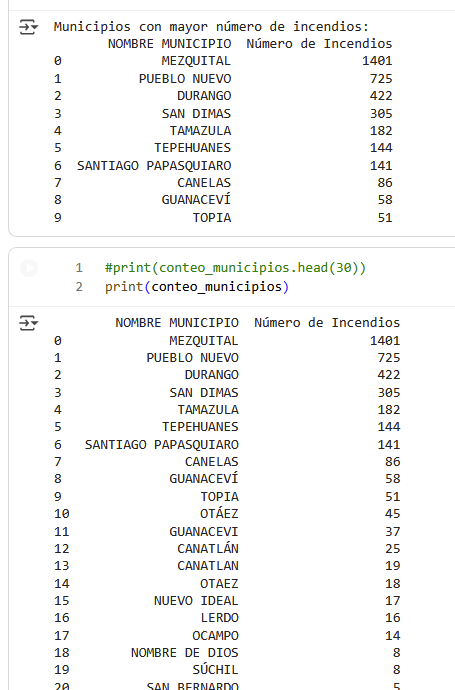

2.   Ya se tiene el feature engineering, para esto del feature FECHA INICIO, se extrajeron valores de mes y año, para calcular la recurrencia y hacer los conteos relacionados con el NOMBRE MUNICIPIO. Ademas se hacer el One-Hot Encodig para el feature NOMBRE MUNICIPIO<br>

Con estas codificacione sya se puedewn aplicar algoritmos como la regresion lineal presentada a continuación

<br>

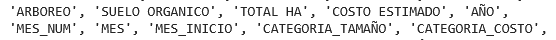

<br>

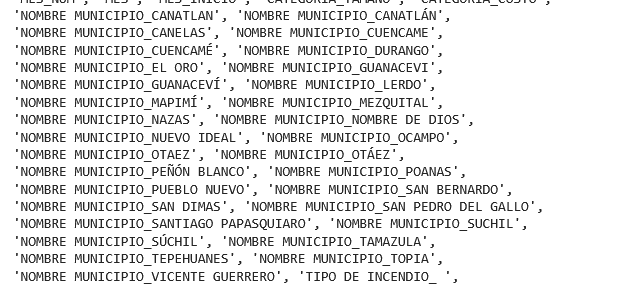


3.   Experimentamos realizando una Regresion Luneal usando las columnas NOMBRE MUNICIPIO, MES y AÑO<br>

<br>

MAE (Mean Absolute Error – Error Absoluto Medio)Es el promedio de las diferencias absolutas entre los valores reales y los predichos.

Esta nedrua de 4.19 nos indica un valor

Nuestro RMSE es de 7.87

Al se mnayor que el MAE, nuestro

In [44]:
df.columns

Index(['CLAVE DE INCENDIO', 'FECHA DE REPORTE', 'LONGITUD GRADOS',
       'LONGITUD MINUTOS', 'LONGITUD SEGUNDOS', 'LATITUD GRADOS',
       'LATITUD MINUTOS', 'LATITUD SEGUNDOS', 'LATITUD', 'LONGITUD',
       'COORDENADAS', 'CLAVE MUNICIPIO', 'NOMBRE MUNICIPIO', 'PREDIO O PARAJE',
       'CAUSA DEL INCENDIO', 'CAUSA ESPECIFICA', 'FECHA INICIO',
       'FECHA LIQUIDACION', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION',
       'ZONA BIOCLIMATICA', 'REGIMEN DE FUEGO', 'ARBOLADO ADULTO', 'RENUEVO',
       'ARBUSTIVO', 'HERBACEO', 'HOJARASCA', 'ARBOREO', 'SUELO ORGANICO',
       'TOTAL HA', 'COSTO ESTIMADO', 'Año', 'Mes_num', 'Mes', 'MES_INICIO',
       'CATEGORIA_TAMAÑO', 'CATEGORIA_COSTO'],
      dtype='object')

In [45]:
df.columns = df.columns.str.upper()

In [46]:
df.columns

Index(['CLAVE DE INCENDIO', 'FECHA DE REPORTE', 'LONGITUD GRADOS',
       'LONGITUD MINUTOS', 'LONGITUD SEGUNDOS', 'LATITUD GRADOS',
       'LATITUD MINUTOS', 'LATITUD SEGUNDOS', 'LATITUD', 'LONGITUD',
       'COORDENADAS', 'CLAVE MUNICIPIO', 'NOMBRE MUNICIPIO', 'PREDIO O PARAJE',
       'CAUSA DEL INCENDIO', 'CAUSA ESPECIFICA', 'FECHA INICIO',
       'FECHA LIQUIDACION', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION',
       'ZONA BIOCLIMATICA', 'REGIMEN DE FUEGO', 'ARBOLADO ADULTO', 'RENUEVO',
       'ARBUSTIVO', 'HERBACEO', 'HOJARASCA', 'ARBOREO', 'SUELO ORGANICO',
       'TOTAL HA', 'COSTO ESTIMADO', 'AÑO', 'MES_NUM', 'MES', 'MES_INICIO',
       'CATEGORIA_TAMAÑO', 'CATEGORIA_COSTO'],
      dtype='object')

In [93]:
df_agrupado = df.groupby(['NOMBRE MUNICIPIO', 'AÑO', 'MES']).size().reset_index(name='CONTEO_INCENDIOS')

print("--- Vista de los datos agrupados ---")
print(df_agrupado.head())
print("-" * 60)

# Convertir 'MES' y 'NOMBRE MUNICIPIO' a formato numérico
features = pd.get_dummies(
    df_agrupado[['NOMBRE MUNICIPIO', 'AÑO', 'MES']],
    columns=['NOMBRE MUNICIPIO', 'MES'],  # Añadimos 'MES' aquí
    drop_first=True
)

target = df_agrupado['CONTEO_INCENDIOS']


# Creamos particiones
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Entrenamiento del Modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Generar las predicciones antes de evaluar
predicciones = modelo.predict(X_test)


# Evaluación del Modelo
mae = mean_absolute_error(y_test, predicciones)
mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)

print("Resultados de la Evaluación del Modelo de Regresión Lineal:")
print("-" * 60)
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape:.2%}")
print(f"Coeficiente de Determinación (R²): {r2:.2f}")

--- Vista de los datos agrupados ---
  NOMBRE MUNICIPIO   AÑO       MES  CONTEO_INCENDIOS
0         CANATLAN  2013  February                 2
1         CANATLAN  2013     March                 1
2         CANATLAN  2013       May                 1
3         CANATLAN  2014      June                 1
4         CANATLAN  2014     March                 2
------------------------------------------------------------
Resultados de la Evaluación del Modelo de Regresión Lineal:
------------------------------------------------------------
Error Absoluto Medio (MAE): 4.89
Error Cuadrático Medio (MSE): 53.21
Raíz del Error Cuadrático Medio (RMSE): 7.29
Error Porcentual Absoluto Medio (MAPE): 239.56%
Coeficiente de Determinación (R²): 0.42


**REGRESION LINEAL FILTRADA**

Buscando mejores resultados en nuestro modelo, intentamos un nuevo filtrado considerando los DAtaSets mas completos, es decir datos del 2023 al 2025, y añadiemos las caracteristicas de TIPO INCENDIO y TIPO VEGETACION.

**COMENTARIOS:**<br>

Se observa que los resultados mejoran considerablemente

In [89]:
print("Tamaño de los conjuntos de datos:")
print("-" * 40)
print(f"Datos de Entrenamiento (Características, X_train): {X_train.shape}")
print(f"Datos de Entrenamiento (Objetivo, y_train):    {y_train.shape}")
print("-" * 40)
print(f"Datos de Prueba (Características, X_test):      {X_test.shape}")
print(f"Datos de Prueba (Objetivo, y_test):       {y_test.shape}")

Tamaño de los conjuntos de datos:
----------------------------------------
Datos de Entrenamiento (Características, X_train): (303, 42)
Datos de Entrenamiento (Objetivo, y_train):    (303,)
----------------------------------------
Datos de Prueba (Características, X_test):      (76, 42)
Datos de Prueba (Objetivo, y_test):       (76,)


##Ahora añadimos la caracteristica CAUSA DEL INCEDIO, correcta unicamente en los años 2023 al 2025

In [90]:
df_filtrado = df[df['AÑO'].isin([2023, 2024, 2025])].copy()

df_filtrado.dropna(subset=['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'CAUSA DEL INCENDIO'], inplace=True)

df_agrupado = df_filtrado.groupby([
    'NOMBRE MUNICIPIO',
    'TIPO DE INCENDIO',
    'TIPO DE VEGETACION',
    'CAUSA DEL INCENDIO', # <-- AÑADIDO AQUÍ
    'AÑO',
    'MES'
]).size().reset_index(name='CONTEO_INCENDIOS')

print("--- Vista de los datos agrupados ---")
print(df_agrupado.head())
print("-" * 60)

target = df_agrupado['CONTEO_INCENDIOS']

features = pd.get_dummies(
    df_agrupado.drop('CONTEO_INCENDIOS', axis=1),
    columns=['NOMBRE MUNICIPIO', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'MES', 'CAUSA DEL INCENDIO'], # <-- AÑADIDO AQUÍ
    drop_first=True
)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
modelo = LinearRegression()
modelo.fit(X_train, y_train)
predicciones = modelo.predict(X_test)

mae = mean_absolute_error(y_test, predicciones)
mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)

print("\nResultados de la Evaluación (con Causa de Incendio):")
print("-" * 60)
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape:.2%}")
print(f"Coeficiente de Determinación (R²): {r2:.2f}")

--- Vista de los datos agrupados ---
  NOMBRE MUNICIPIO TIPO DE INCENDIO     TIPO DE VEGETACION CAUSA DEL INCENDIO  \
0         CANATLÁN      SUPERFICIAL         BOSQUE DE PINO            FOGATAS   
1         CANATLÁN      SUPERFICIAL         BOSQUE DE PINO            FOGATAS   
2         CANATLÁN      SUPERFICIAL         BOSQUE DE PINO            FOGATAS   
3         CANATLÁN      SUPERFICIAL         BOSQUE DE PINO          NATURALES   
4         CANATLÁN      SUPERFICIAL  BOSQUE DE PINO-ENCINO       DESCONOCIDAS   

    AÑO   MES  CONTEO_INCENDIOS  
0  2023  June                 1  
1  2024   May                 1  
2  2025  June                 1  
3  2024   May                 1  
4  2023   May                 1  
------------------------------------------------------------

Resultados de la Evaluación (con Causa de Incendio):
------------------------------------------------------------
Error Absoluto Medio (MAE): 0.97
Error Cuadrático Medio (MSE): 2.05
Raíz del Error Cuadrático Me

##AÑADIMOS DOS CARACTERISTICAS MAS A NUESTRA REGRESION

In [88]:
df_filtrado.dropna(subset=['TIPO DE INCENDIO', 'TIPO DE VEGETACION'], inplace=True)

df_agrupado = df_filtrado.groupby([
    'NOMBRE MUNICIPIO',
    'TIPO DE INCENDIO',
    'TIPO DE VEGETACION',
    'AÑO',
    'MES'
]).size().reset_index(name='CONTEO_INCENDIOS')

print("--- Vista de los datos agrupados (con más detalle) ---")
print(df_agrupado.head())
print("-" * 60)

target = df_agrupado['CONTEO_INCENDIOS']

features = pd.get_dummies(
    df_agrupado.drop('CONTEO_INCENDIOS', axis=1),
    columns=['NOMBRE MUNICIPIO', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'MES'],
    drop_first=True
)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
modelo = LinearRegression()
modelo.fit(X_train, y_train)
predicciones = modelo.predict(X_test)

mae = mean_absolute_error(y_test, predicciones)
mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)

print("\nResultados de la Evaluación (Años 2023-2025, con más características):")
print("-" * 60)
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape:.2%}")
print(f"Coeficiente de Determinación (R²): {r2:.2f}")

--- Vista de los datos agrupados (con más detalle) ---
  NOMBRE MUNICIPIO TIPO DE INCENDIO     TIPO DE VEGETACION   AÑO       MES  \
0         CANATLÁN      SUPERFICIAL         BOSQUE DE PINO  2023      June   
1         CANATLÁN      SUPERFICIAL         BOSQUE DE PINO  2024       May   
2         CANATLÁN      SUPERFICIAL         BOSQUE DE PINO  2025      June   
3         CANATLÁN      SUPERFICIAL  BOSQUE DE PINO-ENCINO  2023       May   
4         CANATLÁN      SUPERFICIAL  BOSQUE DE PINO-ENCINO  2024  February   

   CONTEO_INCENDIOS  
0                 1  
1                 2  
2                 1  
3                 1  
4                 1  
------------------------------------------------------------

Resultados de la Evaluación (Años 2023-2025, con más características):
------------------------------------------------------------
Error Absoluto Medio (MAE): 2.04
Error Cuadrático Medio (MSE): 7.27
Raíz del Error Cuadrático Medio (RMSE): 2.70
Error Porcentual Absoluto Medio (MAPE

#EL PESO DE NUESTRAS CARACTERISTICAS ACTUALES PARA NUESTRA TERCERA REGRESION

In [92]:
columnas_para_agrupar = [
    'NOMBRE MUNICIPIO',
    'TIPO DE INCENDIO',
    'TIPO DE VEGETACION',
    'CAUSA DEL INCENDIO',
    'AÑO',
    'MES'
]
df_agrupado = df.groupby(columnas_para_agrupar, observed=True).size().reset_index(name='CONTEO_INCENDIOS')


target = df_agrupado['CONTEO_INCENDIOS']
features_raw = pd.get_dummies(
    df_agrupado.drop('CONTEO_INCENDIOS', axis=1),
    columns=['NOMBRE MUNICIPIO', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'MES', 'CAUSA DEL INCENDIO'],
    drop_first=True
)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_raw)
features = pd.DataFrame(features_scaled, columns=features_raw.columns)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
modelo = LinearRegression()
modelo.fit(X_train, y_train)

print("--- Importancia de cada Característica en el Modelo ---")
coeficientes = modelo.coef_
importancia_df = pd.DataFrame(
    data={'Característica': features.columns, 'Peso (Coeficiente)': coeficientes}
).sort_values(by='Peso (Coeficiente)', key=abs, ascending=False)
print(importancia_df)

--- Importancia de cada Característica en el Modelo ---
                            Característica  Peso (Coeficiente)
11              NOMBRE MUNICIPIO_MEZQUITAL        2.382201e+00
20           NOMBRE MUNICIPIO_PUEBLO NUEVO        1.394115e+00
54                  TIPO DE VEGETACION_NAN        1.381049e+00
5                 NOMBRE MUNICIPIO_DURANGO        9.018586e-01
43  TIPO DE VEGETACION_BOSQUE DE PINO - BP        8.609762e-01
..                                     ...                 ...
10                 NOMBRE MUNICIPIO_MAPIMÍ        2.539997e-03
12                  NOMBRE MUNICIPIO_NAZAS        9.272932e-04
47            TIPO DE VEGETACION_CHAPARRAL        9.272932e-04
4                NOMBRE MUNICIPIO_CUENCAMÉ        1.457168e-15
46    TIPO DE VEGETACION_BOSQUE DE TÁSCATE        2.775558e-16

[87 rows x 2 columns]


In [ ]:
df2.columns

##VERIFICAMOS LA UTILIDAD DE LAS COORDENADAS Y RECURRENCIA

Primera etapa, para el año 2025

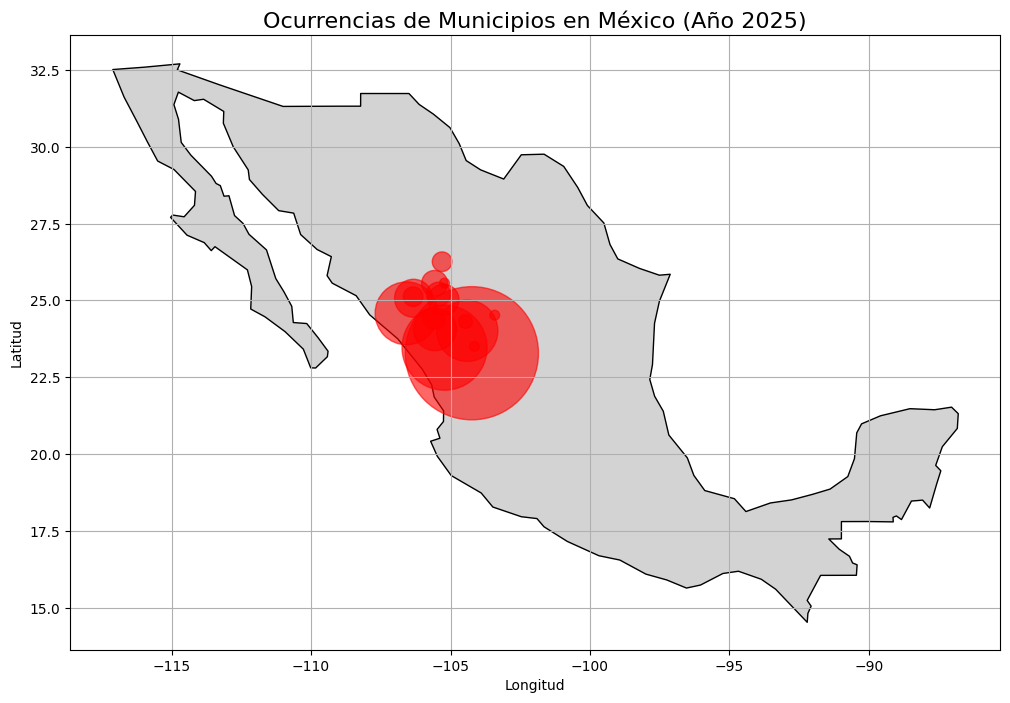

In [55]:
#dataset_fusionado
df_2025 = dataset_fusionado[dataset_fusionado['Año'] == 2025].copy()
municipios_agrupados = df_2025.groupby('NOMBRE MUNICIPIO').agg(
    conteo=('NOMBRE MUNICIPIO', 'size'),
    longitud_municipio=('longitud_municipio', 'first'),
    latitud_municipio=('latitud_municipio', 'first')
).reset_index()

# --- 3. Convertir a GeoDataFrame (sin cambios) ---
gdf_municipios = gpd.GeoDataFrame(
    municipios_agrupados,
    geometry=gpd.points_from_xy(municipios_agrupados.longitud_municipio, municipios_agrupados.latitud_municipio),
    crs="EPSG:4326"
)

# --- 4. Cargar el mapa de México (CÓDIGO CORREGIDO) ---
# Se carga el mapa del mundo desde una URL directa y estable.
world_mapa_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world_mapa = gpd.read_file(world_mapa_url)

# Se filtra para obtener solo el polígono de México
mexico_mapa = world_mapa[world_mapa['NAME'] == 'Mexico']

# --- 5. Crear el mapa (sin cambios) ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
mexico_mapa.plot(ax=ax, color='lightgray', edgecolor='black')
gdf_municipios.plot(
    ax=ax,
    color='red',
    markersize=municipios_agrupados['conteo'] * 50,
    alpha=0.6,
    legend=True
)
ax.set_title('Ocurrencias de Municipios en México (Año 2025)', fontsize=16)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.grid(True)
plt.show()

In [78]:
coordenadas_durango = [24.8, -104.5]
mapa_durango_folium = folium.Map(location=coordenadas_durango, zoom_start=7)


# --- 4. Añadir los puntos (círculos) al mapa ---
for idx, row in municipios_agrupados.iterrows():
    folium.CircleMarker(
        location=[row['latitud_municipio'], row['longitud_municipio']],
        #radius=row['conteo'] * 5,
        radius= 10,
        tooltip=f"{row['NOMBRE MUNICIPIO']}: {row['conteo']}",
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(mapa_durango_folium)

mapa_durango_folium

##Para el historico general 2013-2025

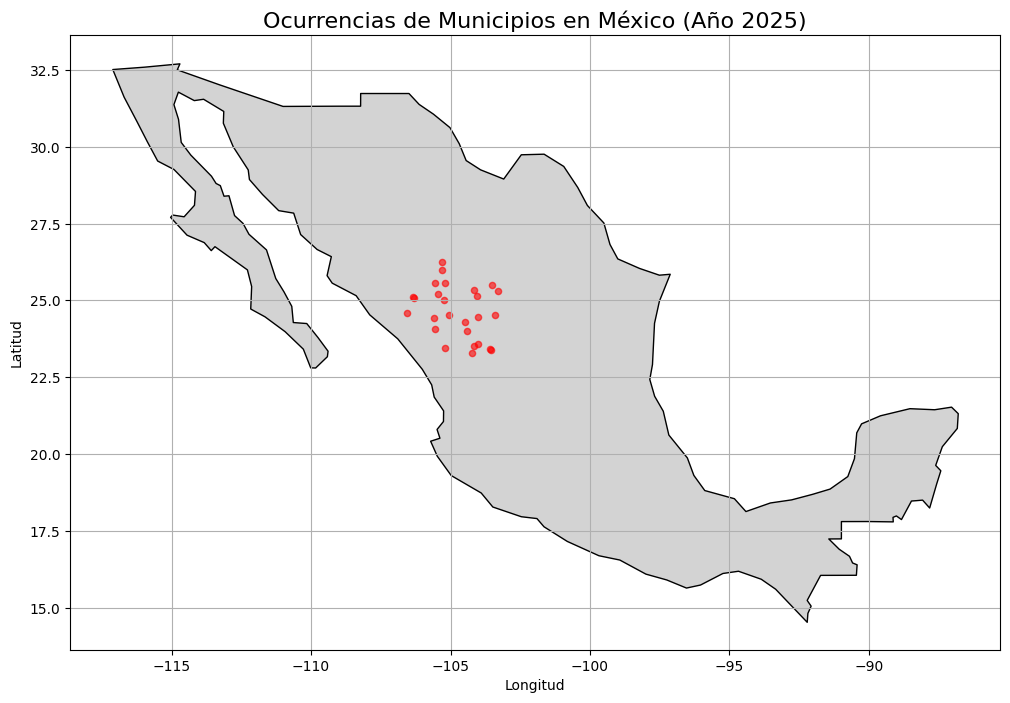

In [82]:
#dataset_fusionado
df_2025 = dataset_fusionado.copy()
municipios_agrupados = df_2025.groupby('NOMBRE MUNICIPIO').agg(
    conteo=('NOMBRE MUNICIPIO', 'size'),
    longitud_municipio=('longitud_municipio', 'first'),
    latitud_municipio=('latitud_municipio', 'first')
).reset_index()

municipios_agrupados.dropna(subset=['latitud_municipio', 'longitud_municipio'], inplace=True)
# Convertir a GeoDataFrame
gdf_municipios = gpd.GeoDataFrame(
    municipios_agrupados,
    geometry=gpd.points_from_xy(municipios_agrupados.longitud_municipio, municipios_agrupados.latitud_municipio),
    crs="EPSG:4326"
)

#Cargar el mapa de México
world_mapa_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world_mapa = gpd.read_file(world_mapa_url)

# Se filtra para obtener solo el polígono de México
mexico_mapa = world_mapa[world_mapa['NAME'] == 'Mexico']

# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
mexico_mapa.plot(ax=ax, color='lightgray', edgecolor='black')
gdf_municipios.plot(
    ax=ax,
    color='red',
    #markersize=municipios_agrupados['conteo'] * 50,
    markersize= 20,
    alpha=0.6,
    legend=True
)
ax.set_title('Ocurrencias de Municipios en México (Año 2025)', fontsize=16)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.grid(True)
plt.show()

In [83]:
coordenadas_durango = [24.8, -104.5]
mapa_durango_folium = folium.Map(location=coordenadas_durango, zoom_start=7)


# --- 4. Añadir los puntos (círculos) al mapa ---
for idx, row in municipios_agrupados.iterrows():
    folium.CircleMarker(
        location=[row['latitud_municipio'], row['longitud_municipio']],
        #radius=row['conteo'] * 5,
        radius= 10,
        tooltip=f"{row['NOMBRE MUNICIPIO']}: {row['conteo']}",
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(mapa_durango_folium)

mapa_durango_folium


4.   Respondemos las preguntas<br>

**¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**<br>
Regresión Lineal y Bosque aleatorio, Para esta entrega exploramos únicamente regresión lineal, basando en las características solidas que se tienen, es decir, para todos los años se tiene nombre del municipio y fecha, permitiendo así calcular la recurrencia y sus probabilidades, para los años 2023 al 2025 podemos añadir las características de tipo de incendio, tipo de vegetación y causa.

Se pretende mejorar el modelo para lograr un bosque robusto, añadiendo características de humedad, temperatura y dirección del viento.

**¿Se puede determinar la importancia de las características para el modelo generado?**<br>
Si, se observó que para los años 2023 a 2025 que cuentan integradas las características de TIPO DE INCENDIO y TIPO DE VEGETACIÓN, el modelo mejoro considerablemente

**¿El modelo está sub/sobreajustando los datos de entrenamiento?**<br>
En este momento, el modelo este sub ajustado, es decir realiza predicciones no muy exactas, un margen de error de entre 4  y 7 incendios predichos erróneamente es muy alto.

**¿Cuál es la métrica adecuada para este problema de negocio?**<br>
MAE o Mean Absolute Error, permite mostrar al usuario del sistema, que no está familiarizado con la IA, el porcentaje de error de nuestra predicción.

**¿Cuál debería ser el desempeño mínimo a obtener?**<br>
Considero que el error aceptable en las predicciones debería de ser de 1 o 2, ya que un margen superior a esto no aporta mucho al tratarse de una actividad muy delicada<br>


5.   CONCLUSIONES<br>
Debido a que el enfoque de operación es, primero saber la probabilidad de una incidencia en un determinado lugar basado en mes y año, para posteriormente relacionarlo con las características de los eventos suscitados en esa determinada ubicación geográfica, municipio o paraje, se tiene un avance significativo, porque  a pesar de la solidez que representa tener la cantidad de eventos en un determinado periodo de tiempo y lugar, para buscar predicciones temporales, se buscara tener el mayor peso de refuerzo de características adicionales como temperatura, humedad y velocidad del viento, de la máxima cantidad de años posibles para poder aumentar la precisión del modelo.
Tener información faltante por no haberse registrado o no formar parte del esquema de datos registrados en un periodo de tiempo, como lo son los años 2013 al 2025, es un gran problema, ya que no se puede rellenar con métricas como promedio, entre otras. Un ejemplo de esto es la causa del incendio, al ser estas únicas y específicas, no se podría por ejemplo asumir que fue por una colilla de cigarro basado en los registros similares de la zona,


<br>

**COMENTARIOS:**<br>

Se observa que

**FUENTES BIBLIOGGRÁFICAS**

•	INEGI. (2023). Clasificadores — Catálogo SCIAN 2023. Instituto Nacional de Estadística y Geografía. https://www.inegi.org.mx/scian/

•	Choudhury, S. (2021). Data analysis and statistical methods for science and engineering (2nd ed.). Wiley. https://www.wiley.com/en-us/Data+Analysis+and+Statistical+Methods+for+Science+and+Engineering%2C+2nd+Edition-p-9781119774797

•	VanderPlas, J. (2016). Python data science handbook: Essential tools for working with data. O'Reilly Media. https://www.oreilly.com/library/view/python-data-science/9781491912127/

•	Instituto Nacional de Estadística y Geografía. (2023). Aspectos geográficos de Durango: Compendio 2022. INEGI.

•	Enríquez Gorgonio, C. (2011). Diseño y construcción de prototipo (CEG11) para un sistema reutilizable de detección de fuego por sensado redundante en el Parque Nacional Cofre de Perote [Tesis de licenciatura, Universidad de Xalapa]. Xalapa, Ver.

•	Belcic, I., & Stryker, C. (2024, 28 de diciembre). ¿Qué es el aprendizaje supervisado? IBM. https://www.ibm.com/mx-es/think/topics/supervised-learning

•	Secretaría de Recursos Naturales y Medio Ambiente. (s. f.). Misión y visión. Gobierno del Estado de Durango. Recuperado el 10 de septiembre de 2025 de https://medioambiente.durango.gob.mx/mision-y-vision%EF%BF%BC

•	Cámara de Diputados del H. Congreso de la Unión. (2015). Ley General de Transparencia y Acceso a la Información Pública. Última reforma publicada en el Diario Oficial de la Federación el 13 de mayo de 2021. Recuperado de https://www.diputados.gob.mx/LeyesBiblio/pdf/LGTAIP.pdf

•	Cámara de Diputados del H. Congreso de la Unión. (2002). Ley Federal de Transparencia y Acceso a la Información Pública. Última reforma publicada en el Diario Oficial de la Federación el 20 de mayo de 2021. Recuperado de https://www.diputados.gob.mx/LeyesBiblio/pdf/LFTAIP.pdf

•	Congreso de la Unión. (2017). Ley General de Protección de Datos Personales en Posesión de Sujetos Obligados. Diario Oficial de la Federación, 26 de enero de 2017. Recuperado de https://www.diputados.gob.mx/LeyesBiblio/pdf/LGPDPPSO.pdf

•	Instituto Nacional de Transparencia, Acceso a la Información y Protección de Datos Personales (INAI). (2015). Lineamientos Generales en Materia de Clasificación y Desclasificación de la Información, así como para la Elaboración de Versiones Públicas. Diario Oficial de la Federación, 15 de junio de 2015. Recuperado de https://www.dof.gob.mx/nota_detalle.php?codigo=5391143&fecha=15/06/2015

•	Instituto Nacional de Transparencia, Acceso a la Información y Protección de Datos Personales (INAI). (2018). Lineamientos Generales de Protección de Datos Personales para el Sector Público. Diario Oficial de la Federación, 26 de enero de 2018. Recuperado de https://www.dof.gob.mx/nota_detalle.php?codigo=5512450&fecha=26/01/2018

•	Congreso del Estado Libre y Soberano de Durango. (2016). Ley de Transparencia y Acceso a la Información Pública del Estado de Durango. Última reforma publicada el 25 de noviembre de 2022. Recuperado de https://congresodurango.gob.mx/Archivos/legislacion/LEY%20DE%20TRANSPARENCIA%20Y%20ACCESO%20A%20LA%20INFORMACION%20PUBLICA.pdf

•	Congreso del Estado Libre y Soberano de Durango. (2018). Ley de Protección de Datos Personales del Estado de Durango. Recuperado de https://congresodurango.gob.mx/Archivos/legislacion/LEY%20DE%20PROTECCION%20DE%20DATOS%20PERSONALES.pdf

•	Bonaccorso, G. (2018). Mastering Machine Learning Algorithms (2.ª ed.). O'Reilly Media. https://www.oreilly.com/library/view/mastering-machine-learning/9781788621113/f240dfcf-f0cf-4e13-9707-2f19695e94e8.xhtml

•	Boehmke, B. (2018). Advanced machine learning with R. O’Reilly Media. https://www.oreilly.com/library/view/advanced-machine-learning/9781838641771/
